In [92]:
# Analysis of the WireMod XZ and YZ angles

In [93]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

In [94]:
Figure_Dir = "/Users/alexanderantonakis/Software/WireMod-Figures/ThetaYZ_SpringProd/"

In [95]:
DATA_DIR = "/Users/alexanderantonakis/WireModProd2Data/"

fd = DATA_DIR + "DATA_PROD2_Angles_Q_AllCalib_Full.root"
fm = DATA_DIR + "MC_PROD2_Angles_Q_AllCalib_Full.root"

rdata_file = ROOT.TFile.Open(fd, "READ")
rmc_file = ROOT.TFile.Open(fm, "READ")

rdata_file.ls()

TFile**		/Users/alexanderantonakis/WireModProd2Data/DATA_PROD2_Angles_Q_AllCalib_Full.root	
 TFile*		/Users/alexanderantonakis/WireModProd2Data/DATA_PROD2_Angles_Q_AllCalib_Full.root	
  KEY: THnSparseT<TArrayD>	hHit0;1	 projection 
  KEY: THnSparseT<TArrayD>	hTrack0;1	 projection 
  KEY: THnSparseT<TArrayD>	hHit1;1	 projection 
  KEY: THnSparseT<TArrayD>	hTrack1;1	 projection 
  KEY: THnSparseT<TArrayD>	hHit2;1	 projection 
  KEY: THnSparseT<TArrayD>	hTrack2;1	 projection 
  KEY: THnSparseT<TArrayD>	hHit3;1	 projection 
  KEY: THnSparseT<TArrayD>	hTrack3;1	 projection 
  KEY: THnSparseT<TArrayD>	hHit4;1	 projection 
  KEY: THnSparseT<TArrayD>	hTrack4;1	 projection 
  KEY: THnSparseT<TArrayD>	hHit5;1	 projection 
  KEY: THnSparseT<TArrayD>	hTrack5;1	 projection 


In [96]:
def get_bin_centers(h):
    x = []
    for num in range(1, h.GetNbinsX()+1):
        x.append(h.GetBinCenter(num))
    return np.array(x)

def get_bin_content(h):
    x = []
    for num in range(1, h.GetNbinsX()+1):
        x.append(h.GetBinContent(num))
    return np.array(x)

def get_bin_width(h):
    dx = abs(h.GetBinCenter(2) - h.GetBinCenter(1))
    return dx


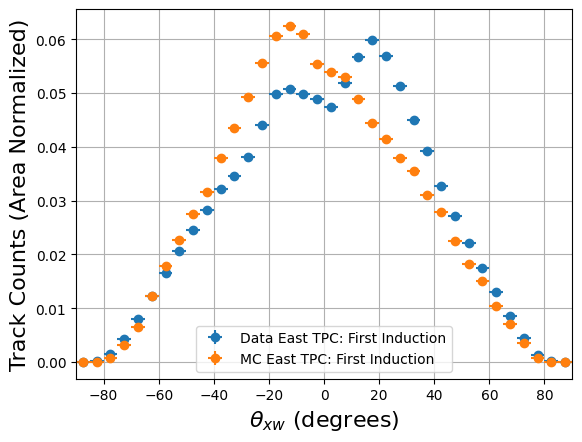

Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_0 (Potential memory leak).


In [97]:
# compare MC and Data track statistics in the East TPC for the first induction plane

h_m = rmc_file.Get("hTrack0")
h_d = rdata_file.Get("hTrack0;1")


h_m_xz_tracks = h_m.Projection(0)
h_d_xz_tracks = h_d.Projection(0)

x = get_bin_centers(h_d_xz_tracks)
y = get_bin_content(h_d_xz_tracks)
w = get_bin_width(h_d_xz_tracks)
N = np.sum(y)
plt.errorbar(x, y/N, xerr=w/2, yerr=np.sqrt(y)/N, fmt='o', label='Data East TPC: First Induction')

x = get_bin_centers(h_m_xz_tracks)
y = get_bin_content(h_m_xz_tracks)
w = get_bin_width(h_m_xz_tracks)
N = np.sum(y)
plt.errorbar(x, y/N, xerr=w/2, yerr=np.sqrt(y)/N, fmt='o', label='MC East TPC: First Induction')

plt.xlabel(r'$\theta_{xw}$ (degrees)', fontsize=16)
plt.ylabel('Track Counts (Area Normalized)', fontsize=16)
plt.xlim(-90, 90)
plt.grid()
plt.legend()
plt.show()

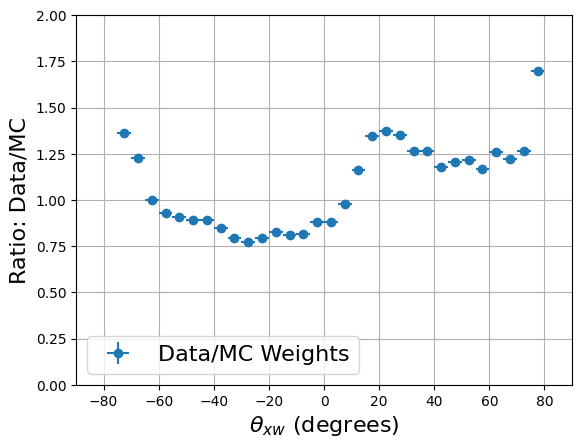

In [98]:
# Calculate the weight ratio

xd = get_bin_centers(h_d_xz_tracks)
yd = get_bin_content(h_d_xz_tracks)
wd = get_bin_width(h_d_xz_tracks)
Nd= np.sum(yd)

xm = get_bin_centers(h_m_xz_tracks)
ym = get_bin_content(h_m_xz_tracks)
wm = get_bin_width(h_m_xz_tracks)
Nm = np.sum(ym)

r = (yd/Nd) / (ym/Nm)


plt.errorbar(x, r, xerr=w/2, yerr=np.sqrt(y)*0, fmt='o', label='Data/MC Weights')

plt.xlabel(r'$\theta_{xw}$ (degrees)', fontsize=16)
plt.ylabel('Ratio: Data/MC', fontsize=16)
plt.xlim(-90, 90)
plt.grid()
plt.legend(fontsize=16)
plt.ylim(0, 2)
plt.show()

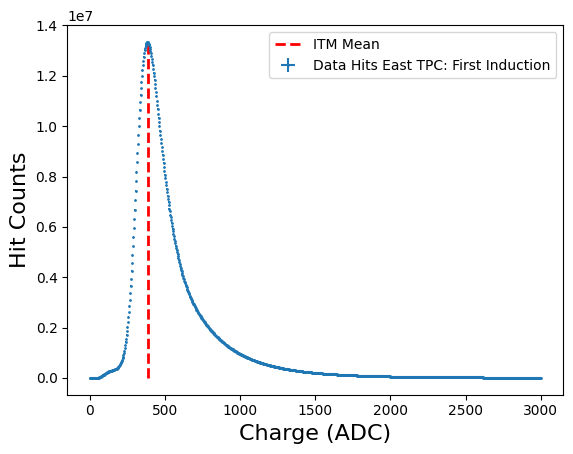

In [99]:
# ITM Python Implementation
from array import array

def ITM(h, sig_down, sig_up, tol, result):

    mean = h.GetMean()
    sd = h.GetRMS()
    if abs(result[0] - mean) < tol:
        #return result
        return array('d', [mean, sd])
    
    # Report error on the mean
    err = sd / (h.Integral()**0.5)
    result[0] = mean
    result[1] = err

    median = array('d', [0.0])
    probs = array('d', [0.5])

    h.GetQuantiles(1, median, probs)

    hnew = h.Clone()
    hnew.Reset()
    for i in range(1, h.GetNbinsX()+1):
        x = h.GetBinCenter(i)
        if h.GetBinLowEdge(i) > median[0] + sig_up * sd or h.GetBinLowEdge(i) + h.GetBinWidth(i) < median[0] + sig_down * sd:
            continue
        hnew.SetBinContent(i, h.GetBinContent(i))
        hnew.SetBinError(i, h.GetBinError(i))

    ITM(hnew, sig_down, sig_up, tol, result)


h_test = rdata_file.Get("hHit0;1").Projection(2)

result = array('d', [0.0, 0.0])
ITM(h_test, -2.0, 1.75, 1e-4, result)


xd = get_bin_centers(h_test)
yd = get_bin_content(h_test)
wd = get_bin_width(h_test)
Nd= np.sum(yd)
plt.errorbar(xd, yd, xerr=wd/2, yerr=np.sqrt(yd), fmt='o', markersize=1, label='Data Hits East TPC: First Induction') 
plt.plot([result[0], result[0]], [0, max(yd)], 'r--', linewidth=2, label='ITM Mean')
plt.xlabel('Charge (ADC)', fontsize=16)
plt.ylabel('Hit Counts', fontsize=16)
plt.legend(fontsize=10)
plt.show()

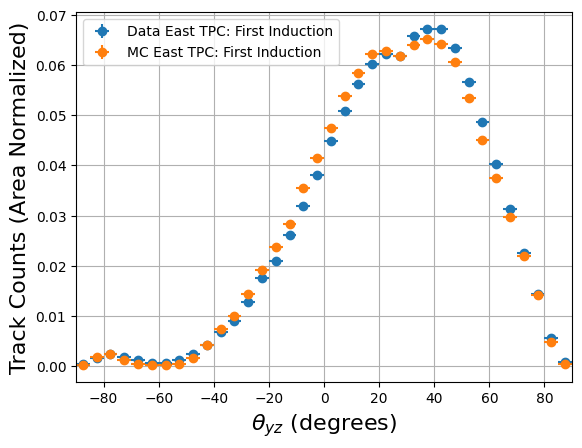

Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).


In [100]:
# compare MC and Data track statistics in the East TPC for the first induction plane

h_m = rmc_file.Get("hTrack0")
h_d = rdata_file.Get("hTrack0;1")


h_m_xz_tracks = h_m.Projection(1)
h_d_xz_tracks = h_d.Projection(1)

x = get_bin_centers(h_d_xz_tracks)
y = get_bin_content(h_d_xz_tracks)
w = get_bin_width(h_d_xz_tracks)
N = np.sum(y)
plt.errorbar(x, y/N, xerr=w/2, yerr=np.sqrt(y)/N, fmt='o', label='Data East TPC: First Induction')

x = get_bin_centers(h_m_xz_tracks)
y = get_bin_content(h_m_xz_tracks)
w = get_bin_width(h_m_xz_tracks)
N = np.sum(y)
plt.errorbar(x, y/N, xerr=w/2, yerr=np.sqrt(y)/N, fmt='o', label='MC East TPC: First Induction')

plt.xlabel(r'$\theta_{yz}$ (degrees)', fontsize=16)
plt.ylabel('Track Counts (Area Normalized)', fontsize=16)
plt.xlim(-90, 90)
plt.grid()
plt.legend()
plt.show()

h_m.Delete()
h_d.Delete()

193450.0


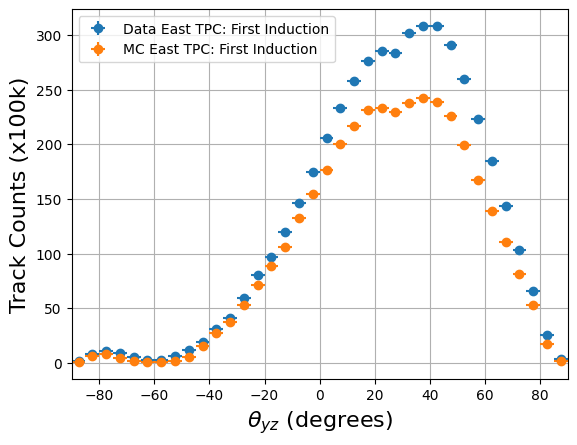

63292.0


Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).


In [101]:
Ntrk = 100000

h_m = rmc_file.Get("hTrack0")
h_d = rdata_file.Get("hTrack0;1")


h_m_xz_tracks = h_m.Projection(1)
h_d_xz_tracks = h_d.Projection(1)

x = get_bin_centers(h_d_xz_tracks)
y = get_bin_content(h_d_xz_tracks)
w = get_bin_width(h_d_xz_tracks)
N = np.sum(y)
plt.errorbar(x, y/Ntrk, xerr=w/2, yerr=np.sqrt(y)/Ntrk, fmt='o', label='Data East TPC: First Induction')

print(np.min(y))

x = get_bin_centers(h_m_xz_tracks)
y = get_bin_content(h_m_xz_tracks)
w = get_bin_width(h_m_xz_tracks)
N = np.sum(y)
plt.errorbar(x, y/Ntrk, xerr=w/2, yerr=np.sqrt(y)/Ntrk, fmt='o', label='MC East TPC: First Induction')

plt.xlabel(r'$\theta_{yz}$ (degrees)', fontsize=16)
plt.ylabel(f'Track Counts (x{int(Ntrk/1000)}k)', fontsize=16)
plt.xlim(-90, 90)
plt.grid()
plt.legend()
plt.show()

h_m.Delete()
h_d.Delete()

print(np.min(y))

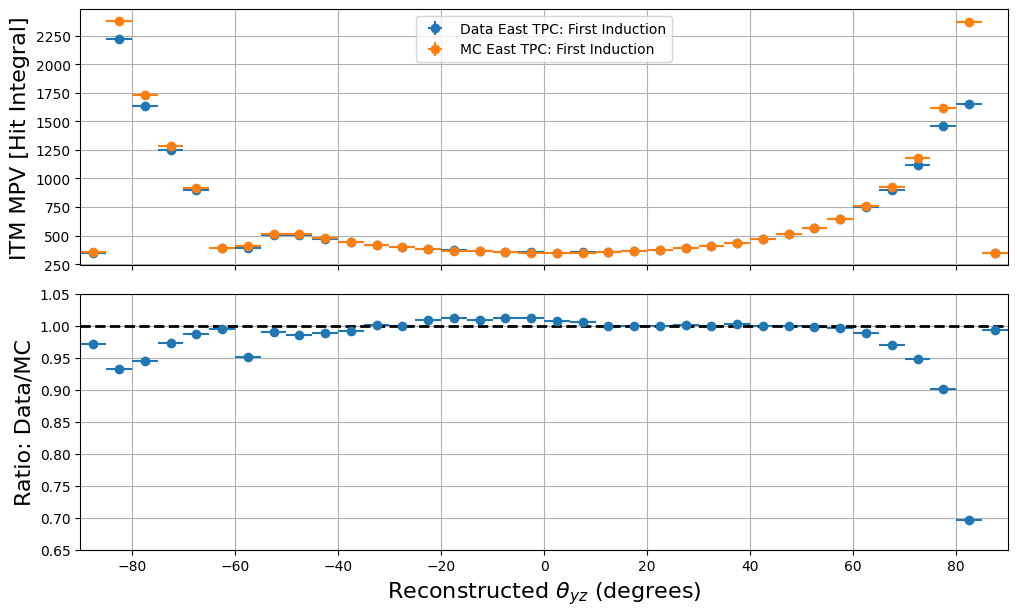

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [102]:
# ITM example without reweighting

h_m = rmc_file.Get("hHit0")
h_d = rdata_file.Get("hHit0;1")

x = get_bin_centers(h_m.Projection(1))
w = get_bin_width(h_m.Projection(1))

mc_mpvs = []
data_mpvs = []

# Profile over the YZ bins
for i in range(1, h_m.GetAxis(1).GetNbins()+1):

    h_m.GetAxis(1).SetRange(i, i)
    hq = h_m.Projection(2)
    result = array('d', [0.0, 0.0])
    ITM(hq, -2.0, 1.75, 1e-4, result)
    mc_mpvs.append(result[0])

# Profile over the YZ bins
for i in range(1, h_d.GetAxis(1).GetNbins()+1):

    h_d.GetAxis(1).SetRange(i, i)
    hq = h_d.Projection(2)
    result = array('d', [0.0, 0.0])
    ITM(hq, -2.0, 1.75, 1e-4, result)
    data_mpvs.append(result[0])

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(10, 6)
)
plt.tight_layout()

ax1.errorbar(x, data_mpvs, xerr=w/2, yerr=np.sqrt(y)*0, fmt='o', label='Data East TPC: First Induction')
ax1.errorbar(x, mc_mpvs, xerr=w/2, yerr=np.sqrt(y)*0, fmt='o', label='MC East TPC: First Induction')

ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
ax1.set_ylabel('ITM MPV [Hit Integral]', fontsize=16)
ax1.grid()
ax1.legend()
ax1.set_xlim(-90, 90)
ax2.set_ylim(0.65, 1.05)
ax2.errorbar(x, np.array(data_mpvs)/np.array(mc_mpvs), xerr=w/2, yerr=np.sqrt(y)*0, fmt='o')
ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
ax2.set_ylabel('Ratio: Data/MC', fontsize=16)
ax2.grid()
plt.show()

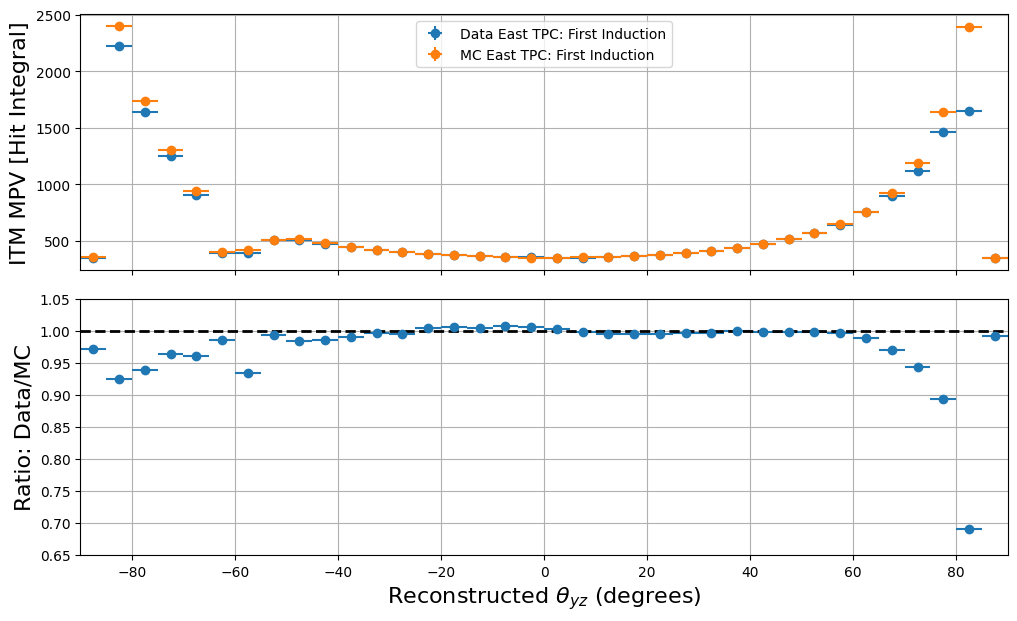

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_0_2 (Potential memory

In [103]:
# Reweighted ITM example

# ITM example without reweighting

h_m = rmc_file.Get("hHit0")
h_d = rdata_file.Get("hHit0;1")

x = get_bin_centers(h_m.Projection(1))
w = get_bin_width(h_m.Projection(1))

mc_mpvs = []
data_mpvs = []

# Profile over the YZ bins
for i in range(1, h_m.GetAxis(1).GetNbins()+1):

    h_m.GetAxis(1).SetRange(i, i)

    h2d = h_m.Projection(2, 0)
    for num in range(len(r)):
        for j in range(1, h2d.GetNbinsY()+1):
            h2d.SetBinContent(num+1, j, h2d.GetBinContent(num+1, j) * r[num])

    hq = h2d.ProjectionY()
    result = array('d', [0.0, 0.0])
    ITM(hq, -2.0, 1.75, 1e-4, result)
    mc_mpvs.append(result[0])


# Profile over the YZ bins
for i in range(1, h_d.GetAxis(1).GetNbins()+1):

    h_d.GetAxis(1).SetRange(i, i)
    hq = h_d.Projection(2)
    result = array('d', [0.0, 0.0])
    ITM(hq, -2.0, 1.75, 1e-4, result)
    data_mpvs.append(result[0])

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(10, 6)
)
plt.tight_layout()

ax1.errorbar(x, data_mpvs, xerr=w/2, yerr=np.sqrt(y)*0, fmt='o', label='Data East TPC: First Induction')
ax1.errorbar(x, mc_mpvs, xerr=w/2, yerr=np.sqrt(y)*0, fmt='o', label='MC East TPC: First Induction')

ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
ax1.set_ylabel('ITM MPV [Hit Integral]', fontsize=16)
ax1.grid()
ax1.legend()
ax1.set_xlim(-90, 90)
ax2.set_ylim(0.65, 1.05)
ax2.errorbar(x, np.array(data_mpvs)/np.array(mc_mpvs), xerr=w/2, yerr=np.sqrt(y)*0, fmt='o')
ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
ax2.set_ylabel('Ratio: Data/MC', fontsize=16)
ax2.grid()
plt.show()

# Variable Binning

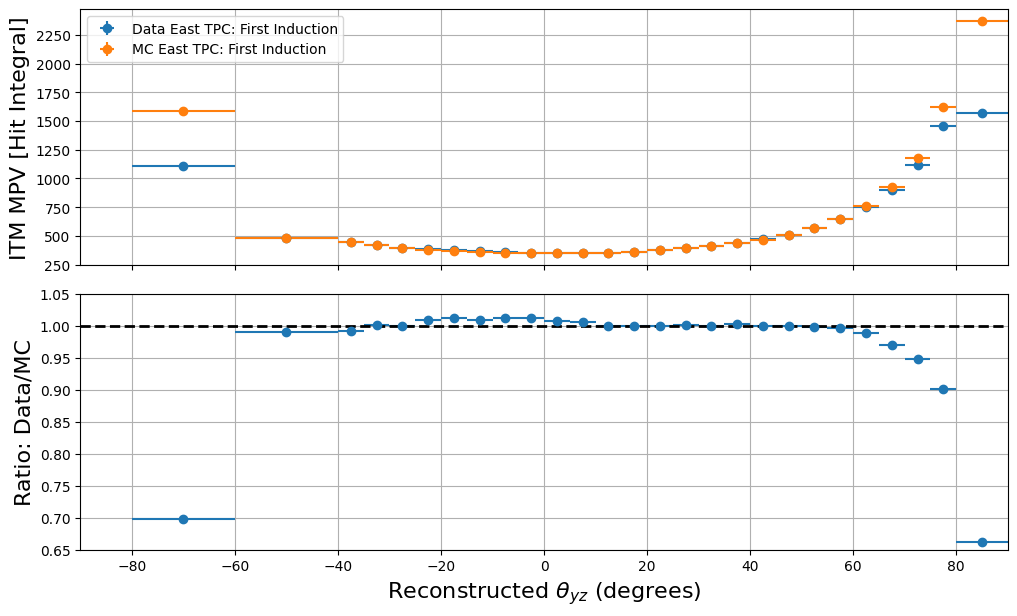

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [104]:
def profile_asymm_first_induction(h):

    mpvs = []
    centers = []
    ws = []

    e1 = h.GetAxis(1).FindBin(-62)
    e2 = h.GetAxis(1).FindBin(-42)
    e3 = h.GetAxis(1).FindBin(82)

    h.GetAxis(1).SetRange(1, e1)
    hq = h.Projection(2)
    result = array('d', [0.0, 0.0])
    ITM(hq, -2.0, 1.75, 1e-4, result)
    mpvs.append(result[0])
    centers.append(-70)
    ws.append(20)

    h.GetAxis(1).SetRange(e1+1, e2)
    hq = h.Projection(2)
    result = array('d', [0.0, 0.0])
    ITM(hq, -2.0, 1.75, 1e-4, result)
    mpvs.append(result[0])
    centers.append(-50)
    ws.append(20)

    for i in range(e2+1, e3):
        
        h.GetAxis(1).SetRange(i, i)

        hq = h.Projection(2)
        result = array('d', [0.0, 0.0])
        ITM(hq, -2.0, 1.75, 1e-4, result)
        mpvs.append(result[0])
        centers.append(h.GetAxis(1).GetBinCenter(i))
        ws.append(h.GetAxis(1).GetBinWidth(i))

    
    h.GetAxis(1).SetRange(e3, h.GetAxis(1).GetNbins()+1)
    hq = h.Projection(2)
    result = array('d', [0.0, 0.0])
    ITM(hq, -2.0, 1.75, 1e-4, result)
    mpvs.append(result[0])
    centers.append(85)
    ws.append(10)

    return np.array(centers), np.array(mpvs), np.array(ws)


fig, (ax1, ax2) = plt.subplots(
    2, 1,
    sharex=True,
    figsize=(10, 6)
)
plt.tight_layout()

h_d = rdata_file.Get("hHit0;1")
x, y, w = profile_asymm_first_induction(h_d)
ax1.errorbar(x, y, xerr=w/2, yerr=np.sqrt(y)*0, fmt='o', label='Data East TPC: First Induction')

h_m = rmc_file.Get("hHit0;1")
xm, ym, wm = profile_asymm_first_induction(h_m)
ax1.errorbar(xm, ym, xerr=wm/2, yerr=np.sqrt(ym)*0, fmt='o', label='MC East TPC: First Induction')

ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
ax1.set_ylabel('ITM MPV [Hit Integral]', fontsize=16)
ax1.grid()
ax1.legend()
ax1.set_xlim(-90, 90)
ax2.set_ylim(0.65, 1.05)
ax2.errorbar(x, np.array(y)/np.array(ym), xerr=w/2, yerr=np.sqrt(y)*0, fmt='o')
ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
ax2.set_ylabel('Ratio: Data/MC', fontsize=16)
ax2.grid()
plt.show()


h_d.Delete()
h_m.Delete()

Plotting TPC 0, Plane 0, Index 0


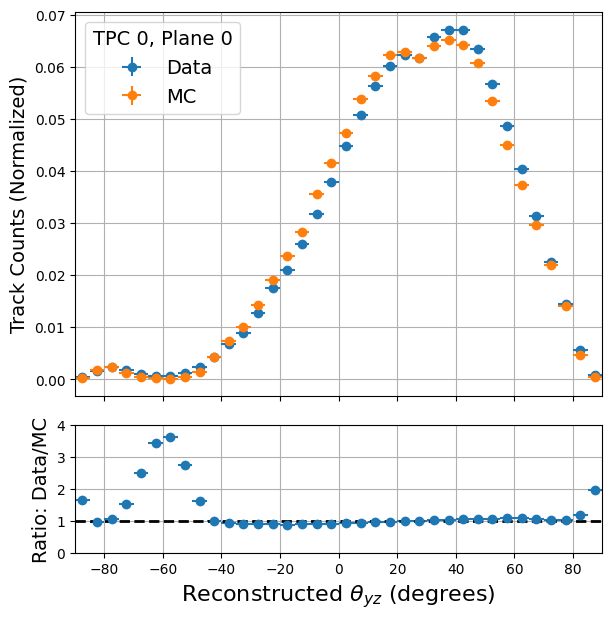

Plotting TPC 0, Plane 1, Index 1


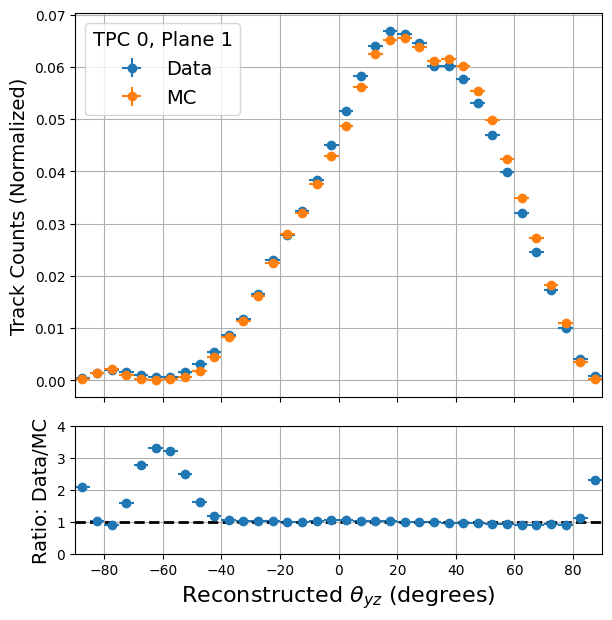

Plotting TPC 0, Plane 2, Index 2


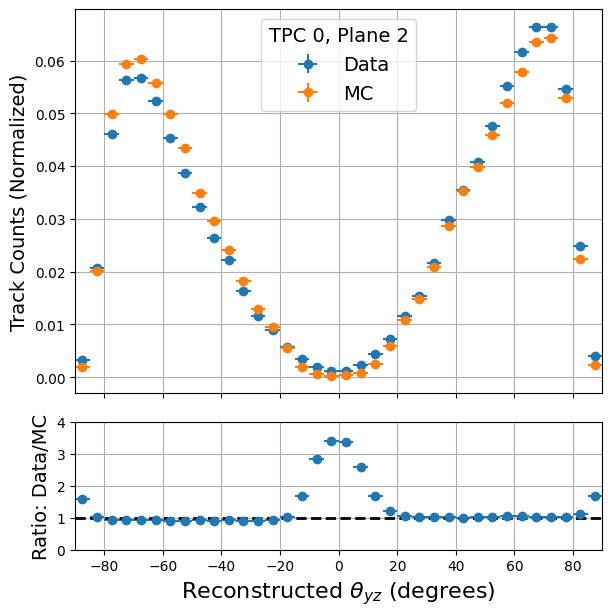

Plotting TPC 1, Plane 0, Index 3


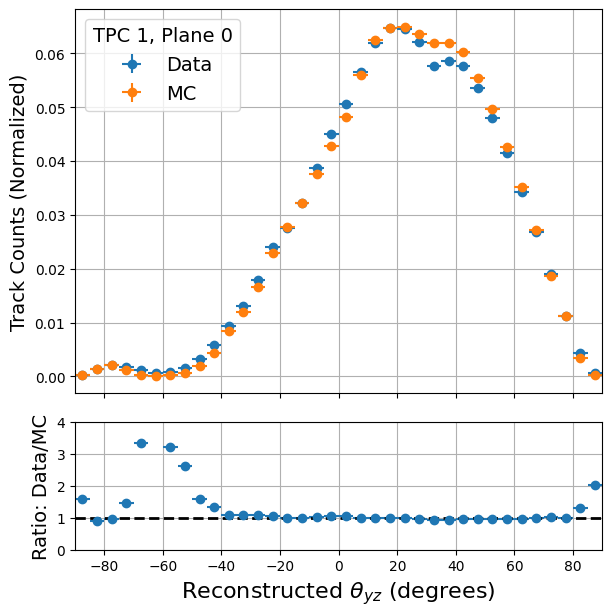

Plotting TPC 1, Plane 1, Index 4


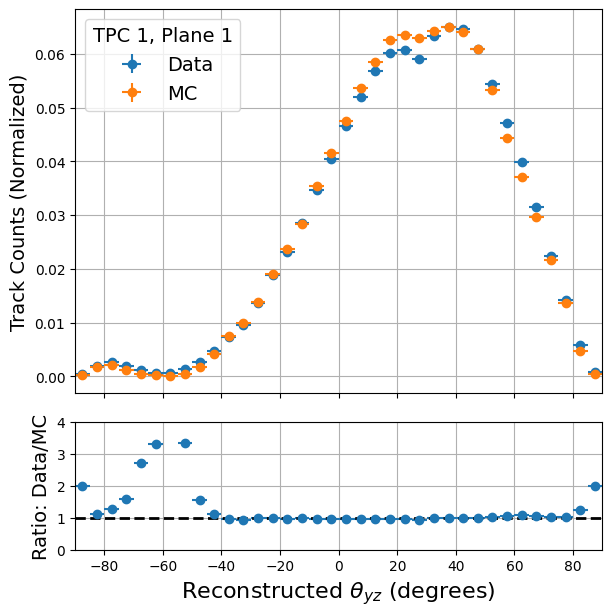

Plotting TPC 1, Plane 2, Index 5


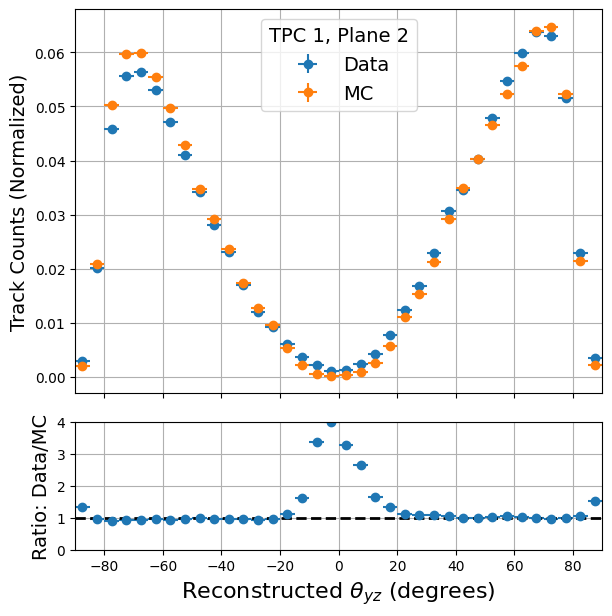

Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack1_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack2_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack3_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack4_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack5_proj_1 (Potential memory leak).


In [105]:
def plot_normalized_comparison_1d(idx, ax1, ax2, dim, cut=None, cut_dim=None):

    h_m = rmc_file.Get("hTrack"+str(idx))
    h_d = rdata_file.Get("hTrack"+str(idx))

    if cut is not None and cut_dim is not None:
        h_m.GetAxis(cut_dim).SetRange(cut[0], cut[1])
        h_d.GetAxis(cut_dim).SetRange(cut[0], cut[1])

    h_m_dim_tracks = h_m.Projection(dim)
    h_d_dim_tracks = h_d.Projection(dim)

    x = get_bin_centers(h_d_dim_tracks)
    y = get_bin_content(h_d_dim_tracks)
    w = get_bin_width(h_d_dim_tracks)
    Nd = np.sum(y)
    ax1.errorbar(x, y/Nd, xerr=w/2, yerr=np.sqrt(y)/Nd, fmt='o', label='Data')

    x = get_bin_centers(h_m_dim_tracks)
    ym = get_bin_content(h_m_dim_tracks)
    w = get_bin_width(h_m_dim_tracks)
    Nm = np.sum(ym)
    ax1.errorbar(x, ym/Nm, xerr=w/2, yerr=np.sqrt(ym)/Nm, fmt='o', label='MC')

    ax2.errorbar(x, (np.array(y)/Nd)/(np.array(ym)/Nm), xerr=w/2, yerr=np.sqrt(y)*0, fmt='o')

for tpc in range(2):
    for plane in range(3):
        idx = tpc * 3 + plane
        print(f"Plotting TPC {tpc}, Plane {plane}, Index {idx}")

        fig, (ax1, ax2) = plt.subplots(
            2, 1,
            sharex=True,
            figsize=(6, 6),
            gridspec_kw={"height_ratios": [3, 1]}  
        )
        plt.tight_layout()

        plot_normalized_comparison_1d(idx, ax1, ax2, 1, cut=None, cut_dim=None)

        ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
        ax1.set_ylabel('Track Counts (Normalized)', fontsize=14)
        ax1.grid()
        ax1.legend(title=f"TPC {tpc}, Plane {plane}", fontsize=14, title_fontsize=14)
        ax1.set_xlim(-90, 90)
        ax2.set_ylim(0, 4)
        ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
        ax2.set_ylabel('Ratio: Data/MC', fontsize=14)
        ax2.grid()
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_TrackCounts_Normalized_Comparison.png", bbox_inches="tight")
        plt.show()
        


Plotting TPC 0, Plane 0, Index 0


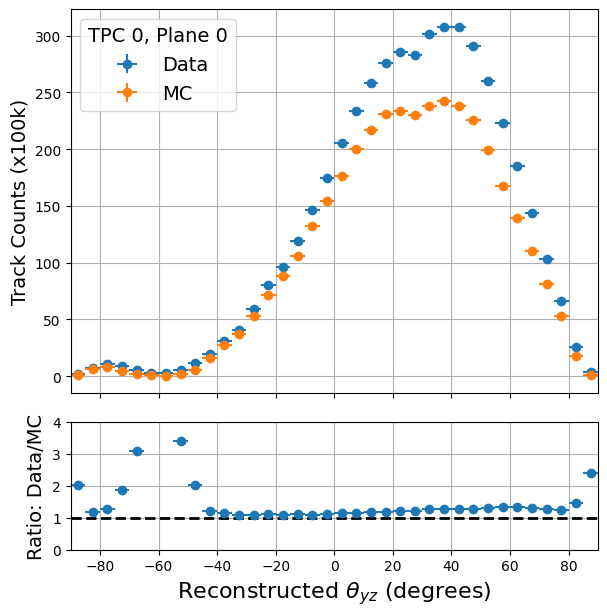

Plotting TPC 0, Plane 1, Index 1


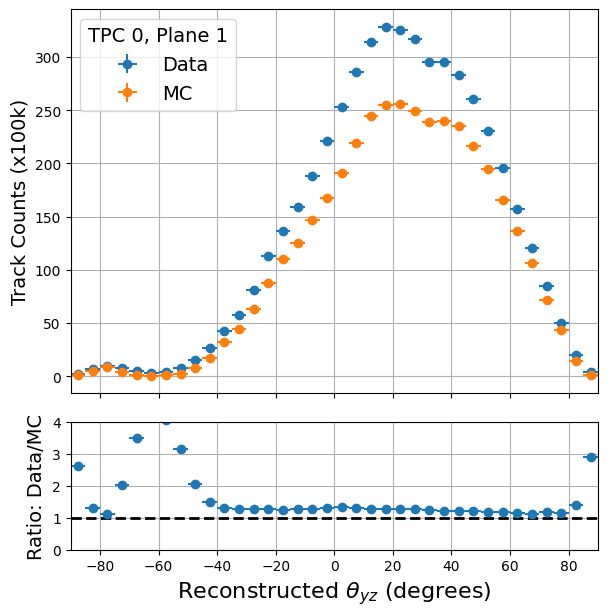

Plotting TPC 0, Plane 2, Index 2


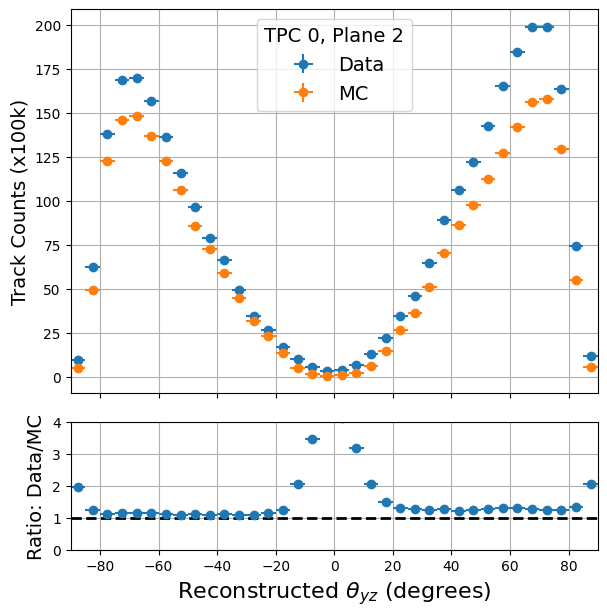

Plotting TPC 1, Plane 0, Index 3


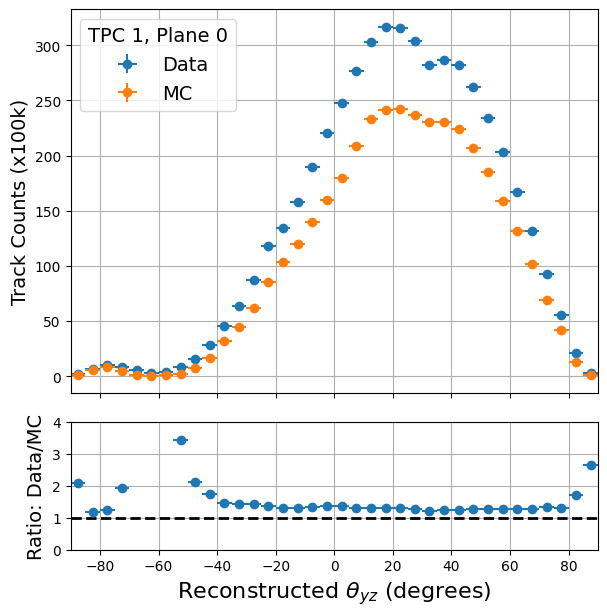

Plotting TPC 1, Plane 1, Index 4


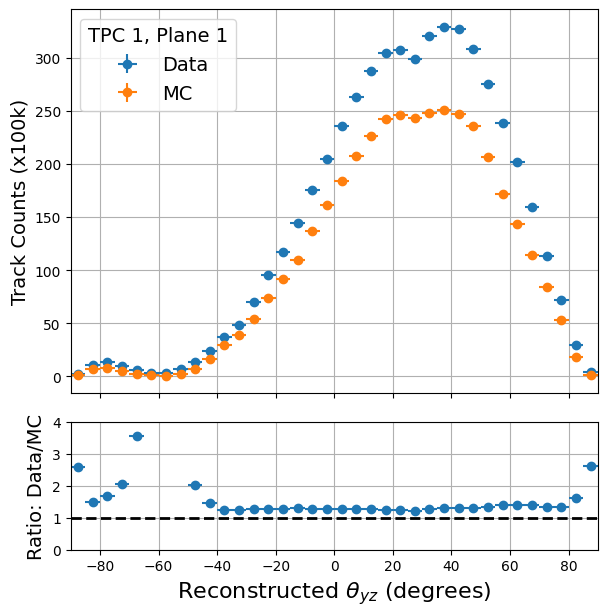

Plotting TPC 1, Plane 2, Index 5


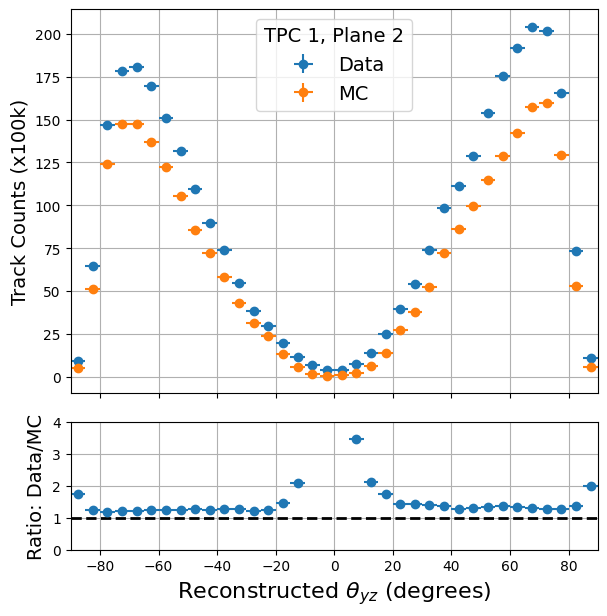

Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack1_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack1_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack2_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack2_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack3_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack3_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack4_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack4_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack5_proj_1 (Potential me

In [106]:
def plot_comparison_1d(idx, ax1, ax2, dim, cut=None, cut_dim=None, norm=100000):

    h_m = rmc_file.Get("hTrack"+str(idx))
    h_d = rdata_file.Get("hTrack"+str(idx))

    if cut is not None and cut_dim is not None:
        h_m.GetAxis(cut_dim).SetRange(cut[0], cut[1])
        h_d.GetAxis(cut_dim).SetRange(cut[0], cut[1])

    h_m_dim_tracks = h_m.Projection(dim)
    h_d_dim_tracks = h_d.Projection(dim)

    x = get_bin_centers(h_d_dim_tracks)
    y = get_bin_content(h_d_dim_tracks)
    w = get_bin_width(h_d_dim_tracks)
    Nd = np.sum(y)
    ax1.errorbar(x, y/norm, xerr=w/2, yerr=np.sqrt(y)/norm, fmt='o', label='Data')

    x = get_bin_centers(h_m_dim_tracks)
    ym = get_bin_content(h_m_dim_tracks)
    w = get_bin_width(h_m_dim_tracks)
    Nm = np.sum(ym)
    ax1.errorbar(x, ym/norm, xerr=w/2, yerr=np.sqrt(ym)/norm, fmt='o', label='MC')

    ax2.errorbar(x, (np.array(y)/norm)/(np.array(ym)/norm), xerr=w/2, yerr=np.sqrt(y)*0, fmt='o')

for tpc in range(2):
    for plane in range(3):
        idx = tpc * 3 + plane
        print(f"Plotting TPC {tpc}, Plane {plane}, Index {idx}")

        fig, (ax1, ax2) = plt.subplots(
            2, 1,
            sharex=True,
            figsize=(6, 6),
            gridspec_kw={"height_ratios": [3, 1]}  
        )
        plt.tight_layout()

        plot_comparison_1d(idx, ax1, ax2, 1, cut=None, cut_dim=None, norm=100000)

        ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
        ax1.set_ylabel('Track Counts (x100k)', fontsize=14)
        ax1.grid()
        ax1.legend(title=f"TPC {tpc}, Plane {plane}", fontsize=14, title_fontsize=14)
        ax1.set_xlim(-90, 90)
        ax2.set_ylim(0, 4)
        ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
        ax2.set_ylabel('Ratio: Data/MC', fontsize=14)
        ax2.grid()
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_TrackCounts_per100k_Comparison.png", bbox_inches="tight")
        plt.show()
        


Plotting TPC 0, Plane 0, Index 0


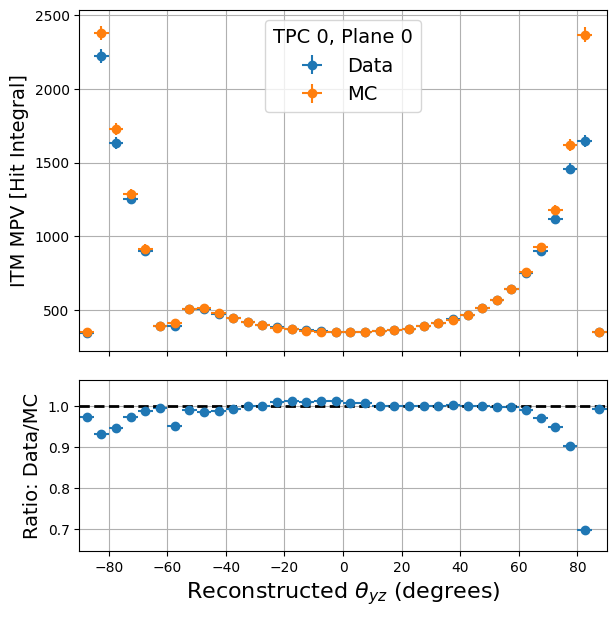

Plotting TPC 0, Plane 1, Index 1


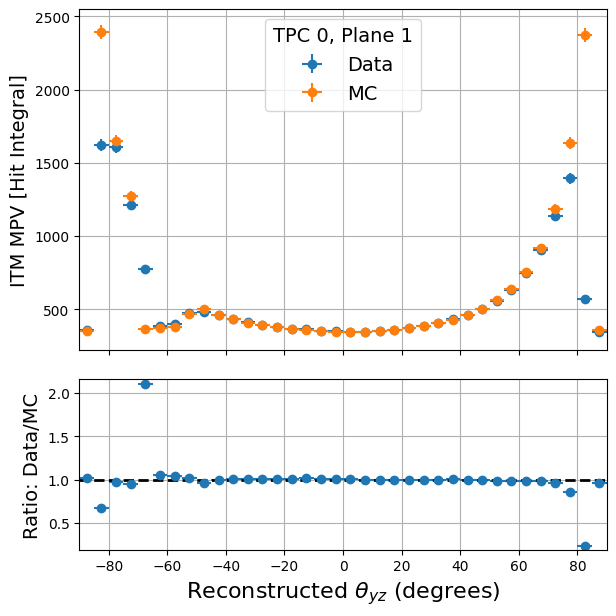

Plotting TPC 0, Plane 2, Index 2


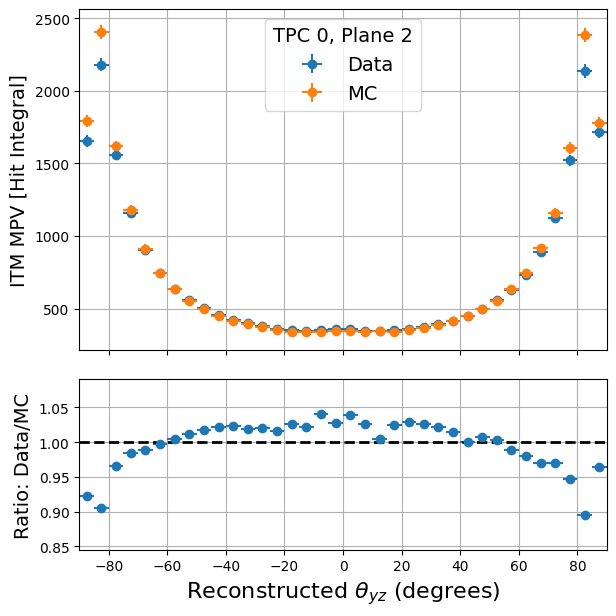

Plotting TPC 1, Plane 0, Index 3


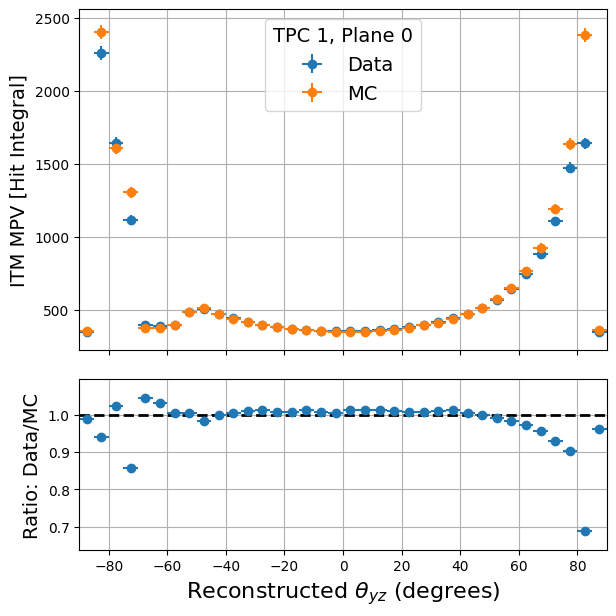

Plotting TPC 1, Plane 1, Index 4


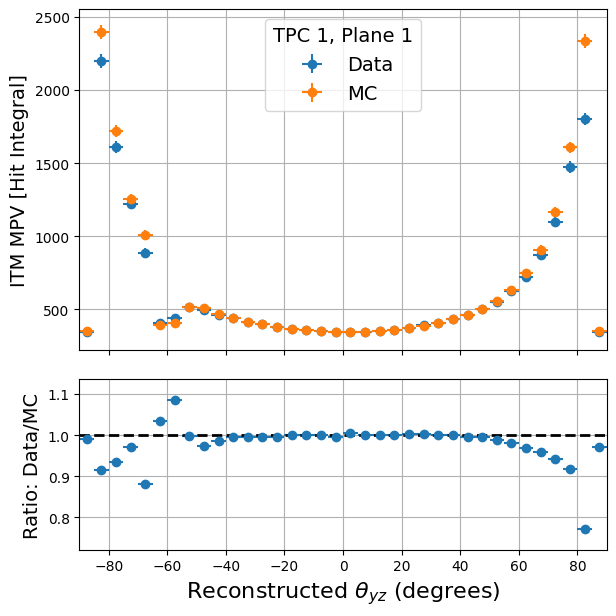

Plotting TPC 1, Plane 2, Index 5


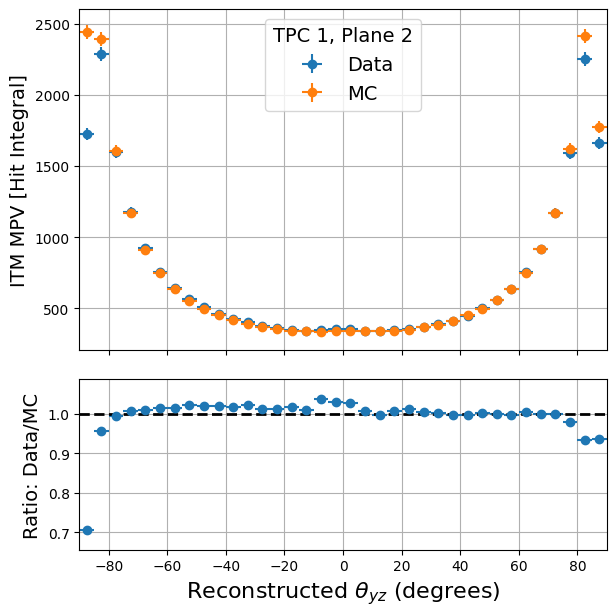

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [107]:
def get_mpv_simple(idx, dim, data=True):
    h = 0
    if data:
        h = rdata_file.Get("hHit"+str(idx))
    else:
        h = rmc_file.Get("hHit"+str(idx))

    x = get_bin_centers(h.Projection(dim))
    w = get_bin_width(h.Projection(dim))

    mpvs = []


    # Profile over the YZ bins
    for i in range(1, h.GetAxis(dim).GetNbins()+1):

        h.GetAxis(dim).SetRange(i, i)

        hq = h.Projection(2)
        result = array('d', [0.0, 0.0])
        ITM(hq, -2.0, 1.75, 1e-4, result)
        mpvs.append(result[0])

    return np.array(x), np.array(mpvs), w


for tpc in range(2):
    for plane in range(3):
        idx = tpc * 3 + plane
        print(f"Plotting TPC {tpc}, Plane {plane}, Index {idx}")

        fig, (ax1, ax2) = plt.subplots(
            2, 1,
            sharex=True,
            figsize=(6, 6),
            gridspec_kw={"height_ratios": [2, 1]}  
        )
        plt.tight_layout()

        x, y, w = get_mpv_simple(idx, 1, data=True)
        xm, ym, wm = get_mpv_simple(idx, 1, data=False)
        ax1.errorbar(x, y, xerr=w/2, yerr=np.sqrt(y), fmt='o', label='Data')
        ax1.errorbar(xm, ym, xerr=w/2, yerr=np.sqrt(ym), fmt='o', label='MC')
        ax2.errorbar(x, np.array(y)/np.array(ym), xerr=w/2, yerr=np.sqrt(y)*0, fmt='o', label='Data/MC')
        r = np.array(y)/np.array(ym)
        ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
        ax1.set_ylabel('ITM MPV [Hit Integral]', fontsize=14)
        ax1.grid()
        ax1.legend(title=f"TPC {tpc}, Plane {plane}", fontsize=14, title_fontsize=14)
        ax1.set_xlim(-90, 90)
        ax2.set_ylim(np.min(r)-0.05, np.max(r)+0.05)
        ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
        ax2.set_ylabel('Ratio: Data/MC', fontsize=14)
        ax2.grid()
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_Charge_Splines_5degrees.png", bbox_inches="tight")
        plt.show()


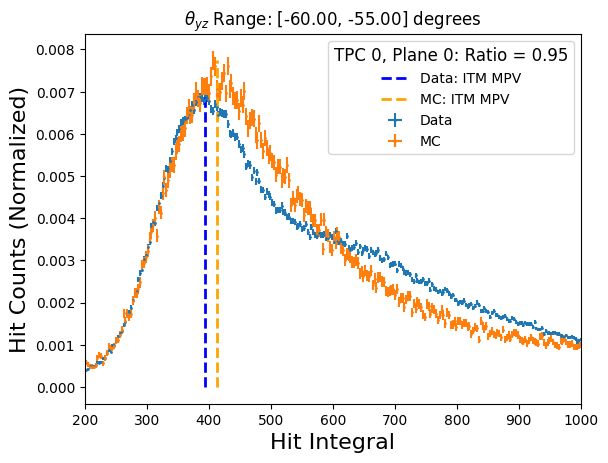

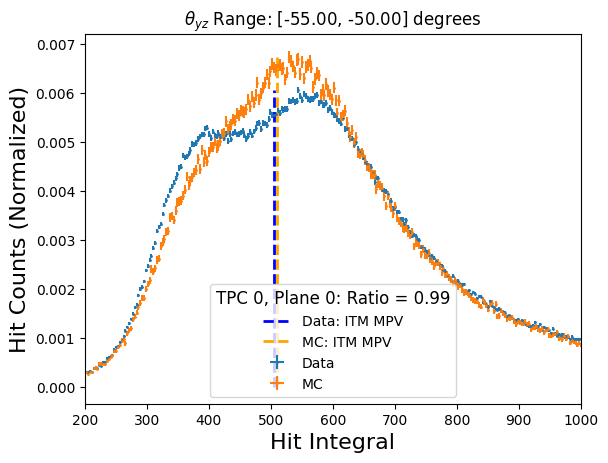

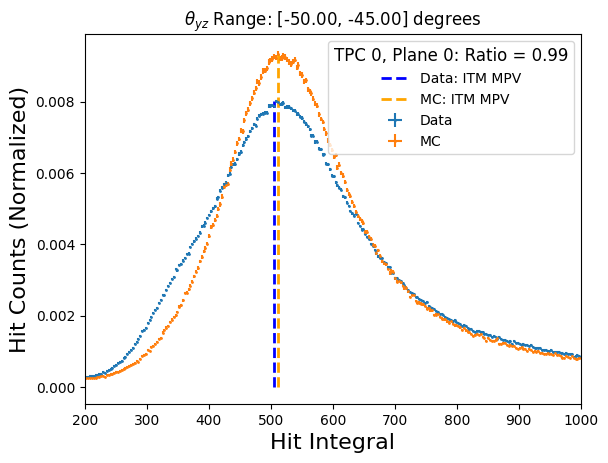

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [108]:
# investigate outliers

tpc = 0
plane = 0
idx = tpc * 3 + plane

hm = rmc_file.Get("hHit"+str(idx))
hd = rdata_file.Get("hHit"+str(idx))

angles = [-59, -53, -47]
count = 0
for a in angles:

    bin1 = hm.GetAxis(1).FindBin(a)
    bin2 = hm.GetAxis(1).FindBin(a)

    xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
    xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

    hm.GetAxis(1).SetRange(bin1, bin2)
    hd.GetAxis(1).SetRange(bin1, bin2)

    hmq = hm.Projection(2)
    hdq = hd.Projection(2)

    result = array('d', [0.0, 0.0])
    ITM(hmq, -2.0, 1.75, 1e-4, result)

    mean_m = result[0]

    result = array('d', [0.0, 0.0])
    ITM(hdq, -2.0, 1.75, 1e-4, result)

    mean_d = result[0]

    r = mean_d / mean_m

    xd = get_bin_centers(hdq)
    yd = get_bin_content(hdq)
    wd = get_bin_width(hdq)

    xm = get_bin_centers(hmq)
    ym = get_bin_content(hmq)
    wm = get_bin_width(hmq)

    Nd= np.sum(yd)
    Nm= np.sum(ym)
    plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
    plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
    plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
    plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
    plt.xlabel('Hit Integral', fontsize=16) 
    plt.ylabel('Hit Counts (Normalized)', fontsize=16)
    plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
    plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
    plt.xlim(200, 1000)
    plt.savefig(Figure_Dir + f"Outlier_AngleYZ_{count}_TPC{tpc}_Plane{plane}_HitIntegral_Comparison.png", bbox_inches="tight")
    plt.show()
    count += 1
hm.Delete()
hd.Delete()

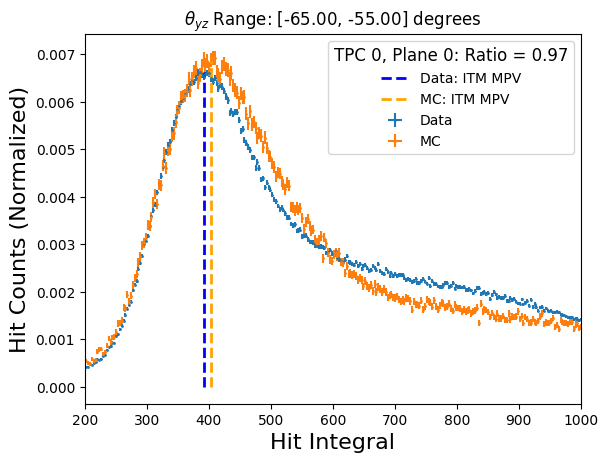

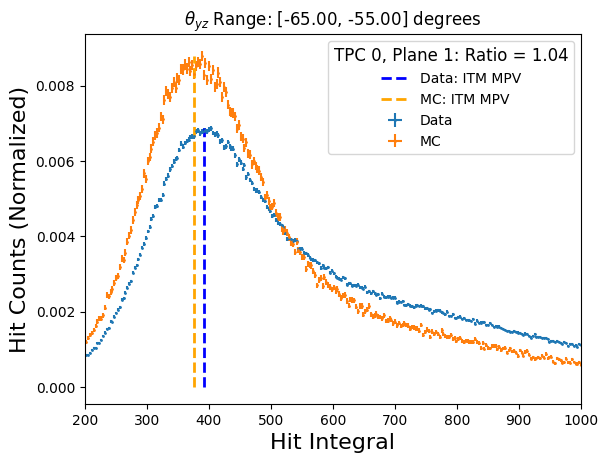

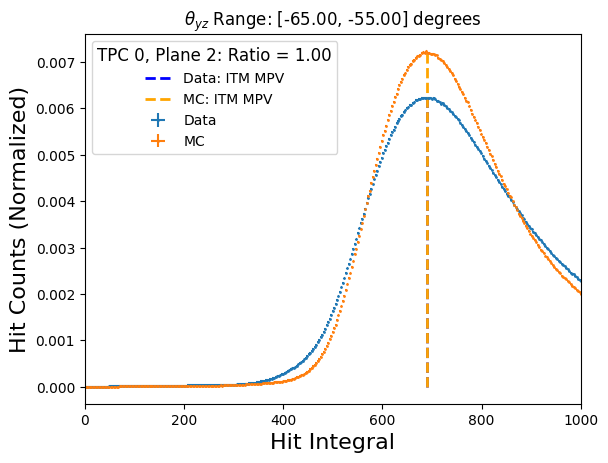

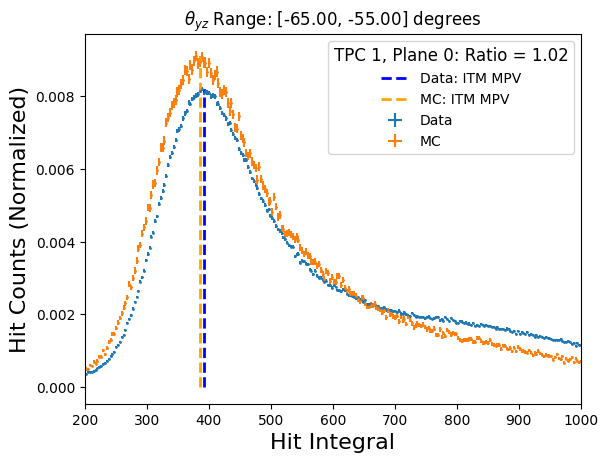

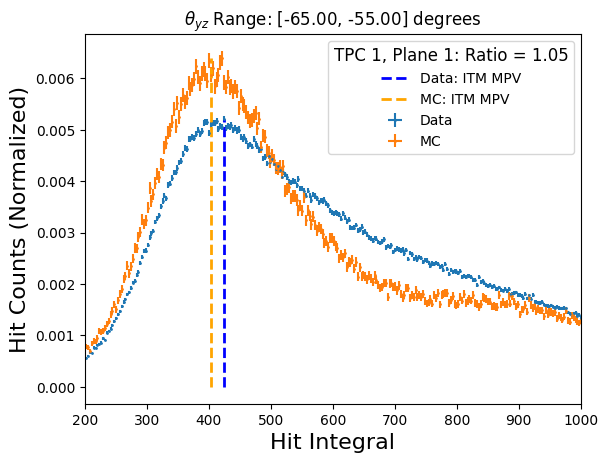

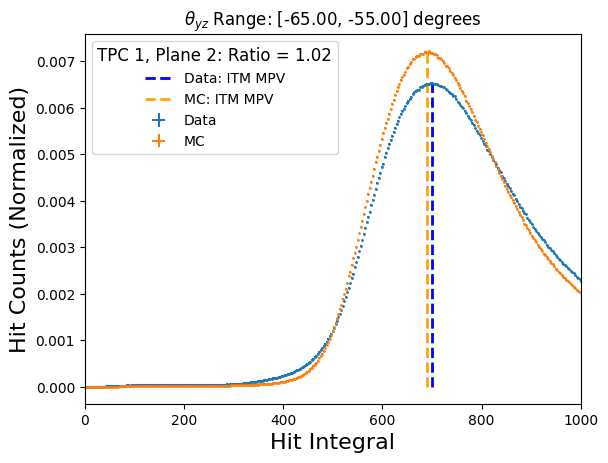

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [109]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(1).FindBin(-62)
        bin2 = hm.GetAxis(1).FindBin(-58)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        plt.xlim(200, 1000)
        if plane == 2:
            plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_neg_65_55.png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

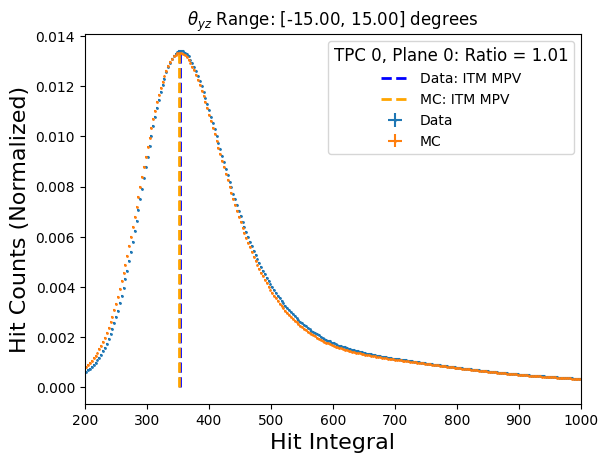

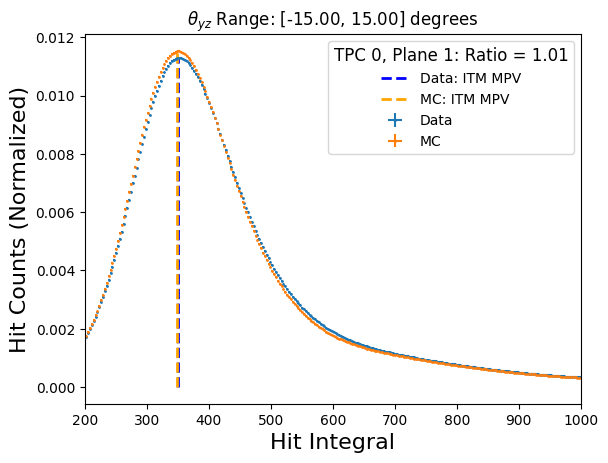

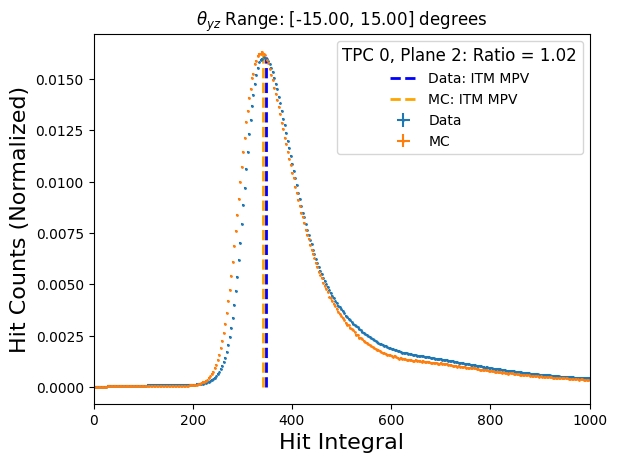

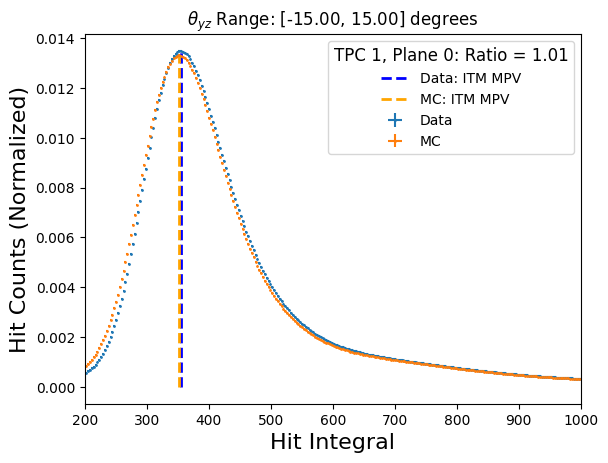

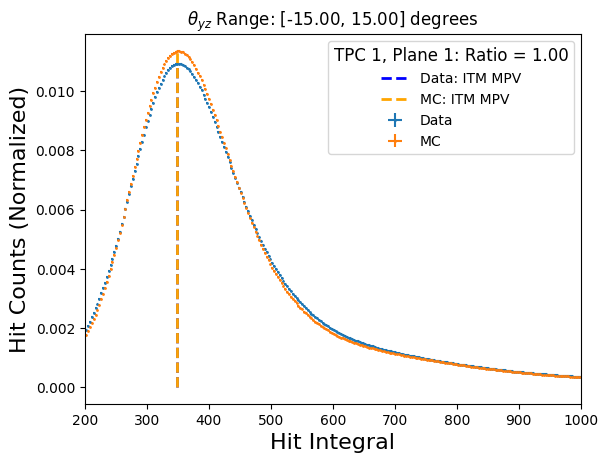

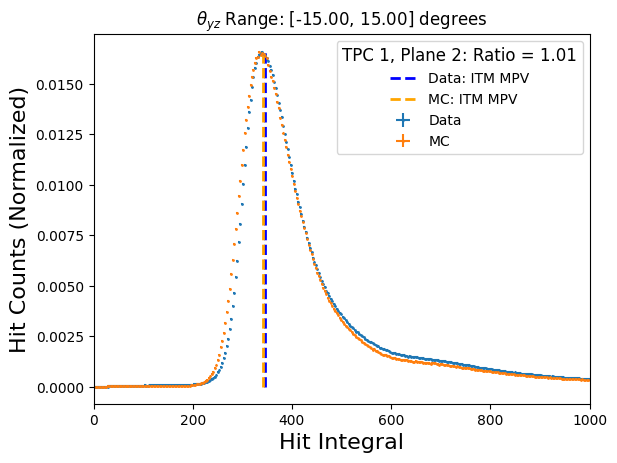

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [110]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(1).FindBin(-14)
        bin2 = hm.GetAxis(1).FindBin(14)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        plt.xlim(200, 1000)
        if plane == 2:
            plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_neg_15_pos_15.png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

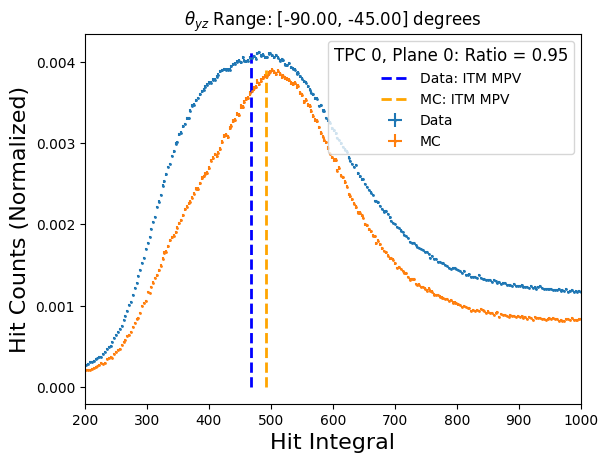

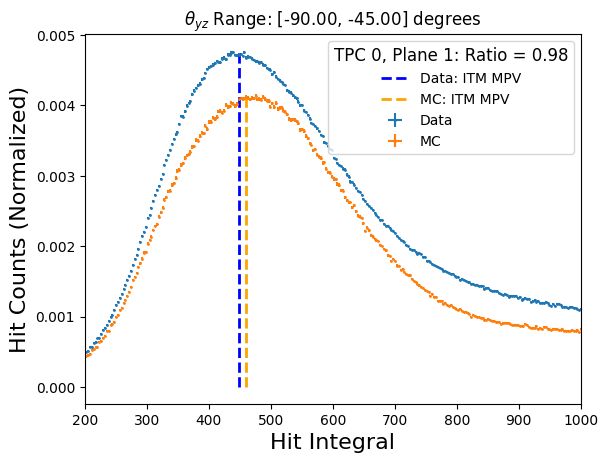

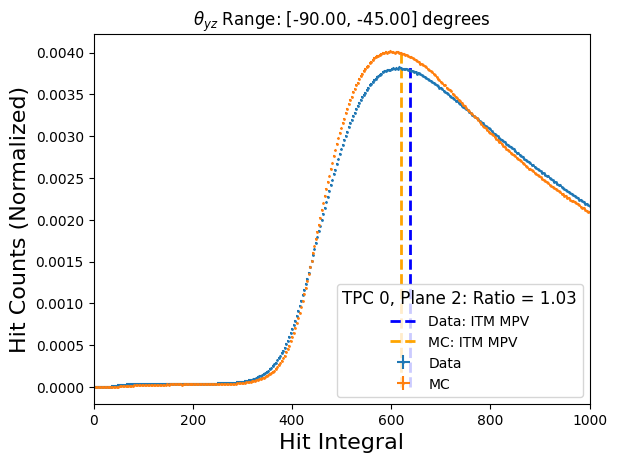

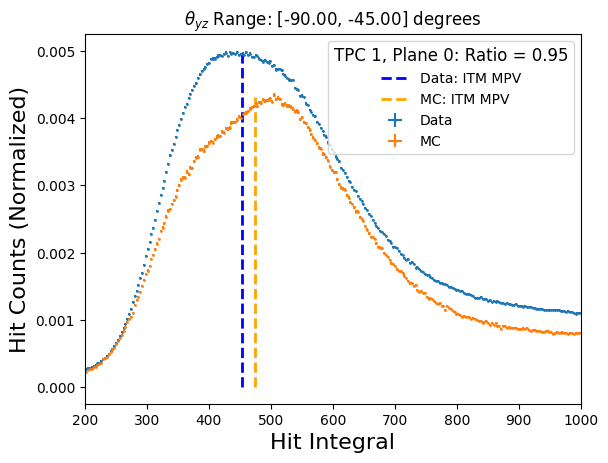

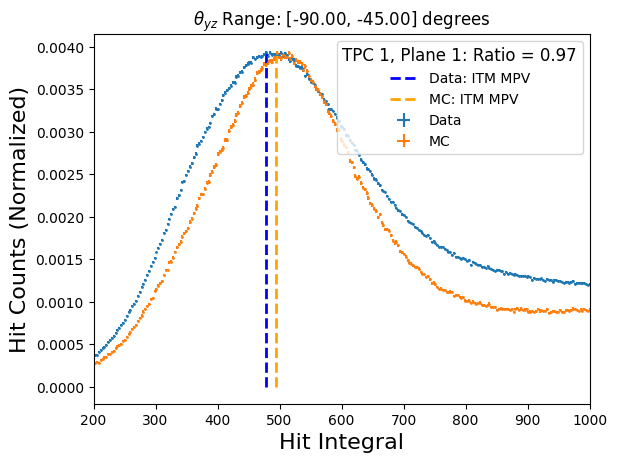

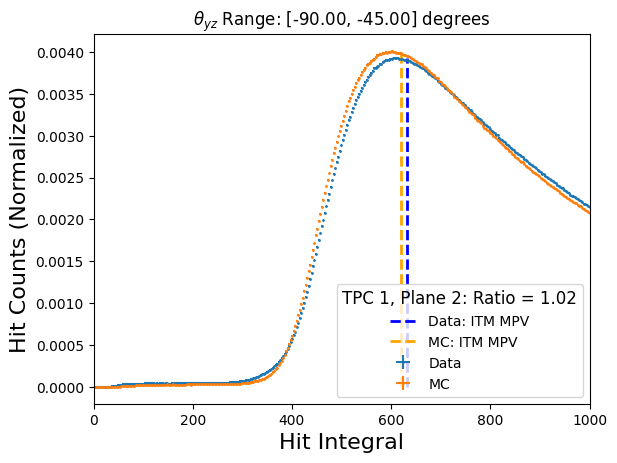

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [111]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(1).FindBin(-89)
        bin2 = hm.GetAxis(1).FindBin(-46)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        plt.xlim(200, 1000)
        if plane == 2:
            plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_neg_90_45.png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

Plotting TPC 0, Plane 0, Index 0


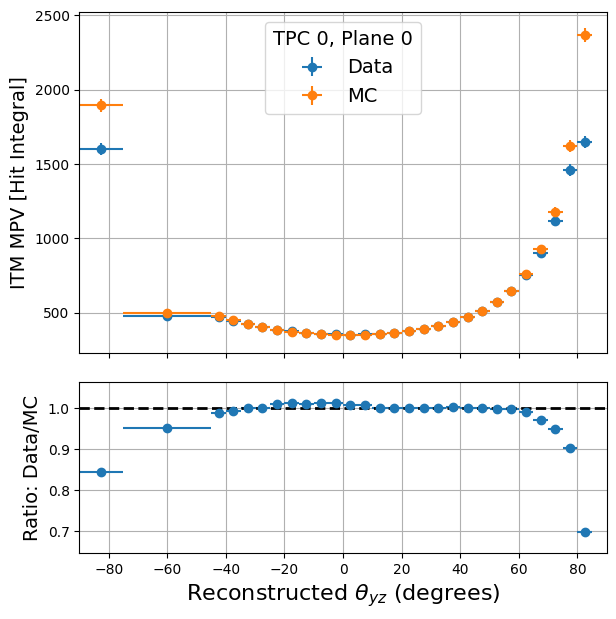

Plotting TPC 0, Plane 1, Index 1


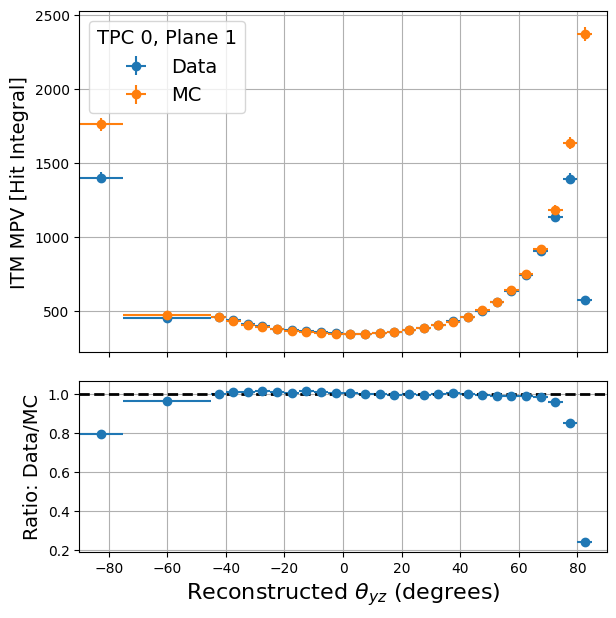

Plotting TPC 0, Plane 2, Index 2


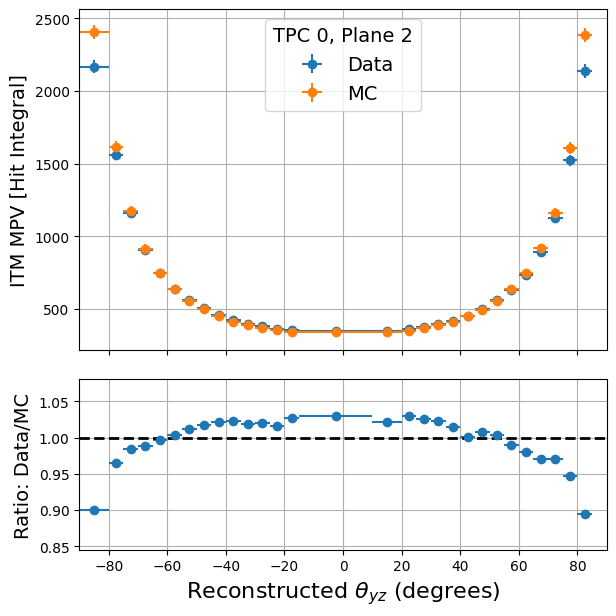

Plotting TPC 1, Plane 0, Index 3


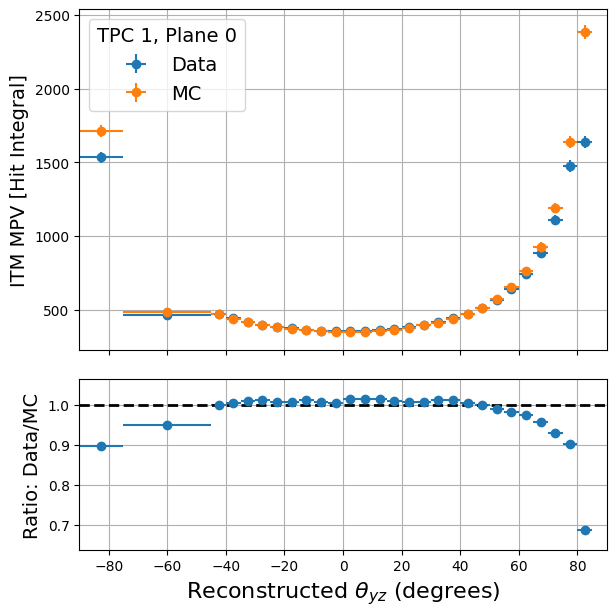

Plotting TPC 1, Plane 1, Index 4


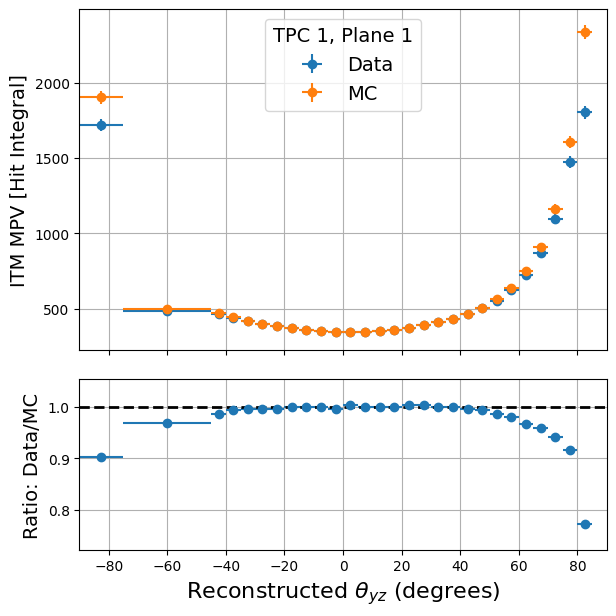

Plotting TPC 1, Plane 2, Index 5


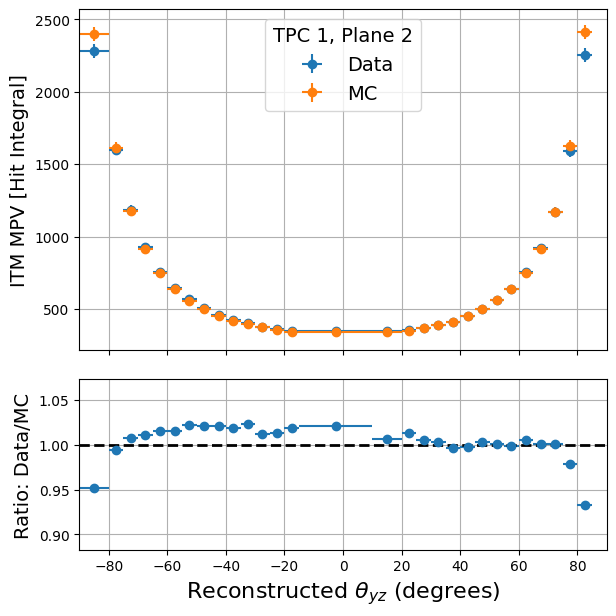

Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).


In [112]:
def get_mpv_variable_binning(idx, dim, threshold=100000, cut_dim=None, cut=None):
    
    hd_trk = rdata_file.Get("hTrack"+str(idx))
    hm_trk = rmc_file.Get("hTrack"+str(idx))

    hd = rdata_file.Get("hHit"+str(idx))
    hm = rmc_file.Get("hHit"+str(idx))

    if cut_dim is not None and cut is not None:
        bin1 = hd_trk.GetAxis(cut_dim).FindBin(cut[0])
        bin2 = hd_trk.GetAxis(cut_dim).FindBin(cut[1])
        hd_trk.GetAxis(cut_dim).SetRange(bin1, bin2)
        hm_trk.GetAxis(cut_dim).SetRange(bin1, bin2)
        hd.GetAxis(cut_dim).SetRange(bin1, bin2)
        hm.GetAxis(cut_dim).SetRange(bin1, bin2)


    Ntrk_d = np.sum(get_bin_content(hd_trk.Projection(dim)))
    Ntrk_m = np.sum(get_bin_content(hm_trk.Projection(dim)))
  
    x = []
    w = []
    mpvs_m = []
    mpvs_d = []

    bins = []
    N = 0
    # Profile over the YZ bins
    for i in range(1, hd_trk.GetAxis(dim).GetNbins()+1):

        Ncurr = 0
        if Ntrk_d > Ntrk_m:
            hm_trk.GetAxis(dim).SetRange(i, i)
            Ncurr = hm_trk.Projection(dim).Integral()
        else:
            hd_trk.GetAxis(dim).SetRange(i, i)
            Ncurr = hd_trk.Projection(dim).Integral()

        if N + Ncurr > threshold:
            if len(bins) == 0:
                hd.GetAxis(dim).SetRange(i, i)
                hm.GetAxis(dim).SetRange(i, i)
                hq_d = hd.Projection(2)
                hq_m = hm.Projection(2)
                result = array('d', [0.0, 0.0])
                ITM(hq_d, -2.0, 1.75, 1e-4, result)
                mpvs_d.append(result[0])
                result = array('d', [0.0, 0.0])
                ITM(hq_m, -2.0, 1.75, 1e-4, result)
                mpvs_m.append(result[0])

                x.append(hm.GetAxis(dim).GetBinCenter(i))
                w.append(hm.GetAxis(dim).GetBinWidth(i))

            else:
                hd.GetAxis(dim).SetRange(bins[0], i)
                hm.GetAxis(dim).SetRange(bins[0], i)
                hq_d = hd.Projection(2)
                hq_m = hm.Projection(2)
                result = array('d', [0.0, 0.0])
                ITM(hq_d, -2.0, 1.75, 1e-4, result)
                mpvs_d.append(result[0])
                result = array('d', [0.0, 0.0])
                ITM(hq_m, -2.0, 1.75, 1e-4, result)
                mpvs_m.append(result[0])

                x.append((hm.GetAxis(dim).GetBinUpEdge(i) + hm.GetAxis(dim).GetBinLowEdge(bins[0]))/2)
                w.append((hm.GetAxis(dim).GetBinUpEdge(i) - hm.GetAxis(dim).GetBinLowEdge(bins[0])))
                
            N = 0
            bins = []

        else:
            bins.append(i)
            N += Ncurr

    return np.array(x), np.array(mpvs_d), np.array(mpvs_m), np.array(w)


for tpc in range(2):
    for plane in range(3):
        idx = tpc * 3 + plane
        print(f"Plotting TPC {tpc}, Plane {plane}, Index {idx}")

        fig, (ax1, ax2) = plt.subplots(
            2, 1,
            sharex=True,
            figsize=(6, 6),
            gridspec_kw={"height_ratios": [2, 1]}  
        )
        plt.tight_layout()

        x, yd, ym, w = get_mpv_variable_binning(idx, 1, threshold=1000000)
        
        ax1.errorbar(x, yd, xerr=w/2, yerr=np.sqrt(yd), fmt='o', label='Data')
        ax1.errorbar(x, ym, xerr=w/2, yerr=np.sqrt(ym), fmt='o', label='MC')
        ax2.errorbar(x, yd/ym, xerr=w/2, yerr=np.sqrt(yd)*0, fmt='o', label='Data/MC')
        r = yd/ym
        ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
        ax1.set_ylabel('ITM MPV [Hit Integral]', fontsize=14)
        ax1.grid()
        ax1.legend(title=f"TPC {tpc}, Plane {plane}", fontsize=14, title_fontsize=14)
        ax1.set_xlim(-90, 90)
        ax2.set_ylim(np.min(r)-0.05, np.max(r)+0.05)
        ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
        ax2.set_ylabel('Ratio: Data/MC', fontsize=14)
        ax2.grid()
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_Charge_Splines_1mil.png", bbox_inches="tight")
        plt.show()


Plotting TPC 0, Plane 0, Index 0


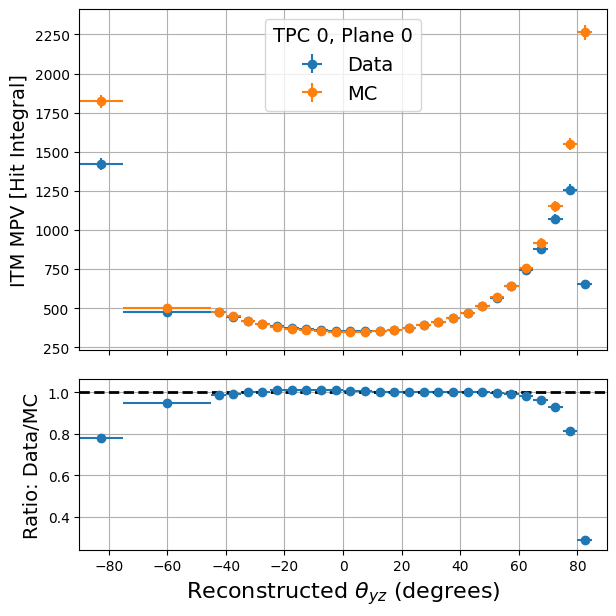

Plotting TPC 0, Plane 1, Index 1


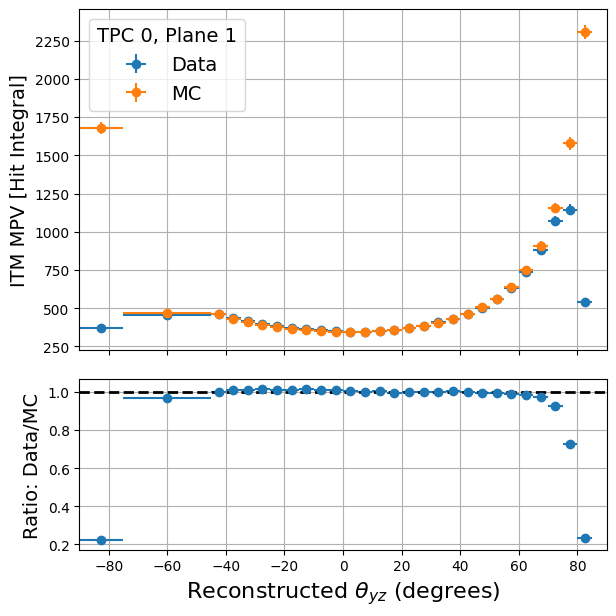

Plotting TPC 0, Plane 2, Index 2


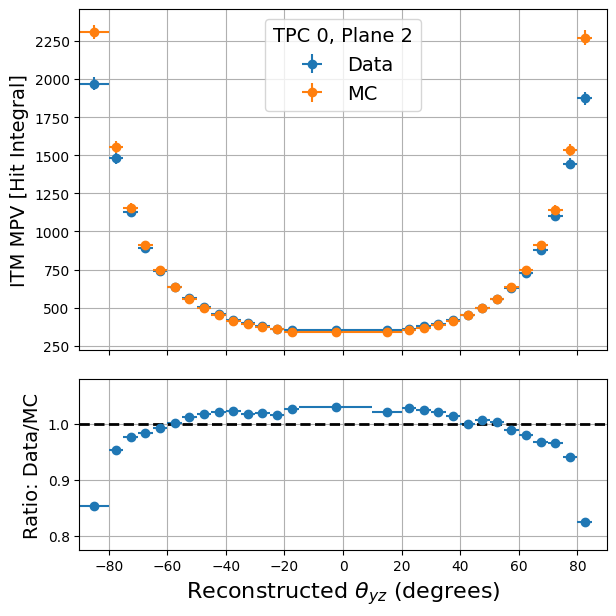

Plotting TPC 1, Plane 0, Index 3


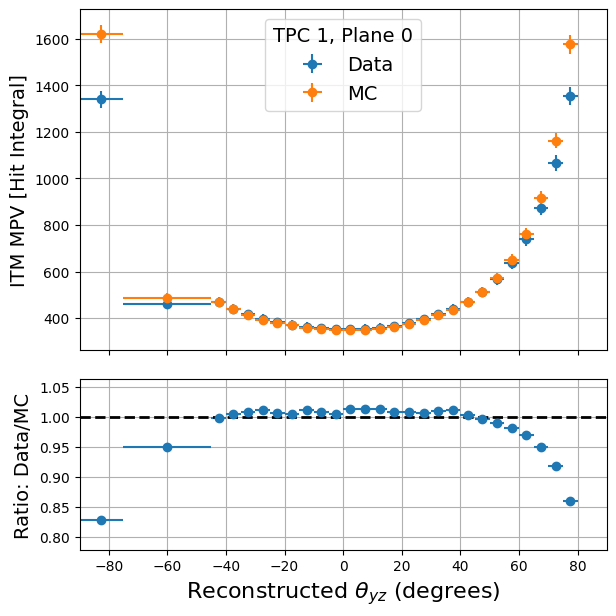

Plotting TPC 1, Plane 1, Index 4


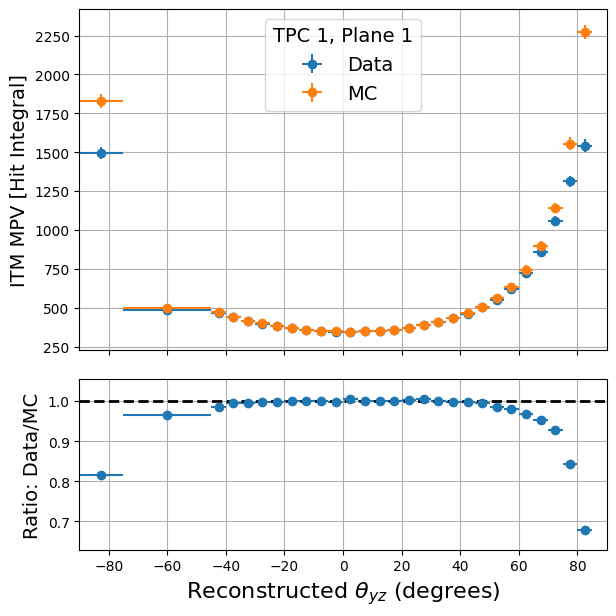

Plotting TPC 1, Plane 2, Index 5


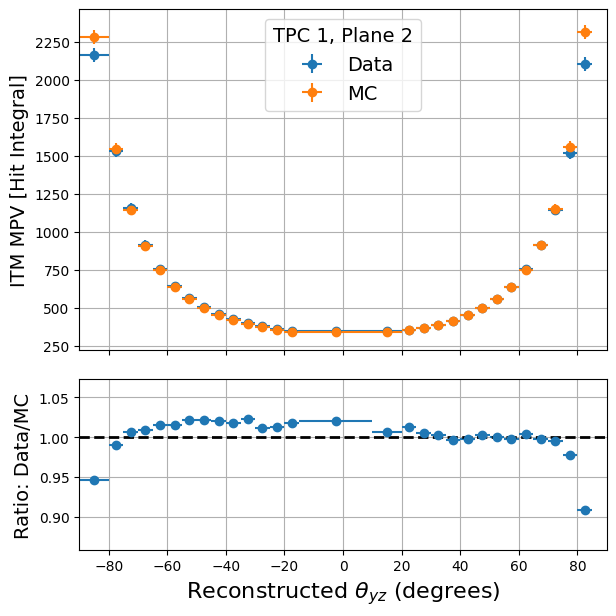

Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).


In [113]:
for tpc in range(2):
    for plane in range(3):
        idx = tpc * 3 + plane
        print(f"Plotting TPC {tpc}, Plane {plane}, Index {idx}")

        fig, (ax1, ax2) = plt.subplots(
            2, 1,
            sharex=True,
            figsize=(6, 6),
            gridspec_kw={"height_ratios": [2, 1]}  
        )
        plt.tight_layout()

        x, yd, ym, w = get_mpv_variable_binning(idx, 1, threshold=1000000, cut_dim=0, cut=(-60, 60))
        
        ax1.errorbar(x, yd, xerr=w/2, yerr=np.sqrt(yd), fmt='o', label='Data')
        ax1.errorbar(x, ym, xerr=w/2, yerr=np.sqrt(ym), fmt='o', label='MC')
        ax2.errorbar(x, yd/ym, xerr=w/2, yerr=np.sqrt(yd)*0, fmt='o', label='Data/MC')
        r = yd/ym
        ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
        ax1.set_ylabel('ITM MPV [Hit Integral]', fontsize=14)
        ax1.grid()
        ax1.legend(title=f"TPC {tpc}, Plane {plane}", fontsize=14, title_fontsize=14)
        ax1.set_xlim(-90, 90)
        ax2.set_ylim(np.min(r)-0.05, np.max(r)+0.05)
        ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
        ax2.set_ylabel('Ratio: Data/MC', fontsize=14)
        ax2.grid()
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_Charge_Splines_1mil.png", bbox_inches="tight")
        plt.show()

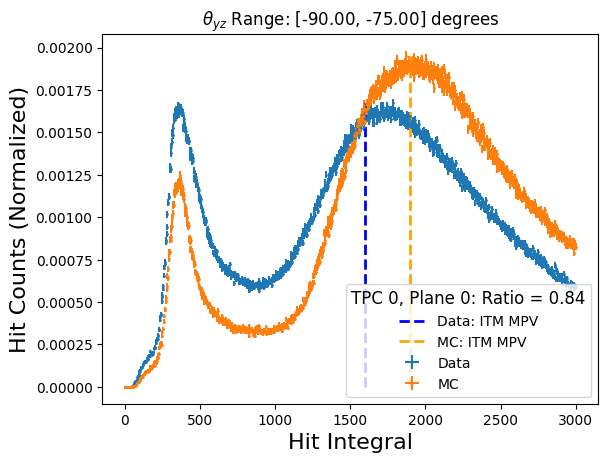

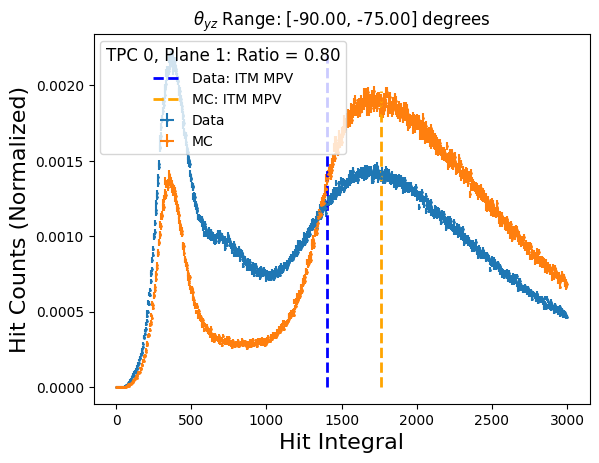

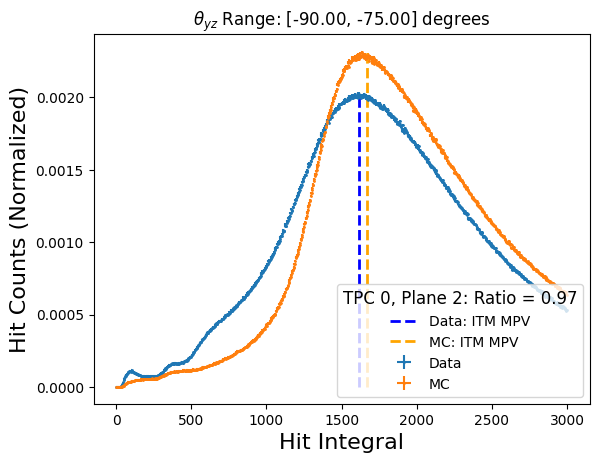

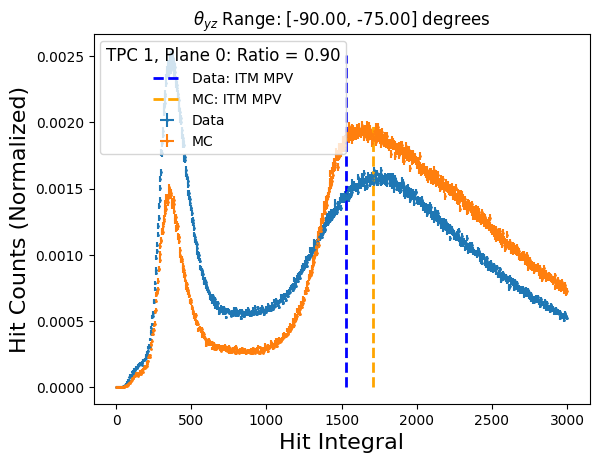

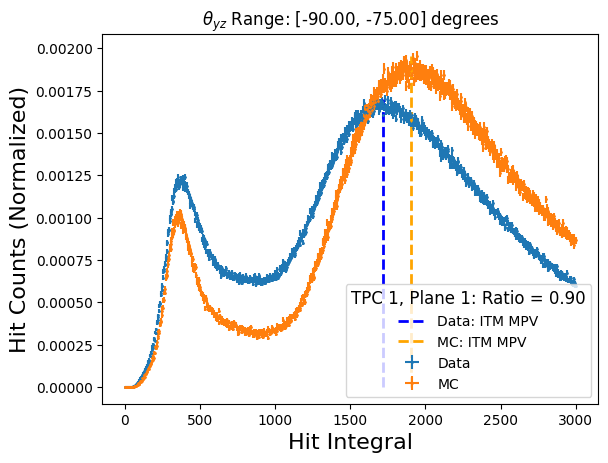

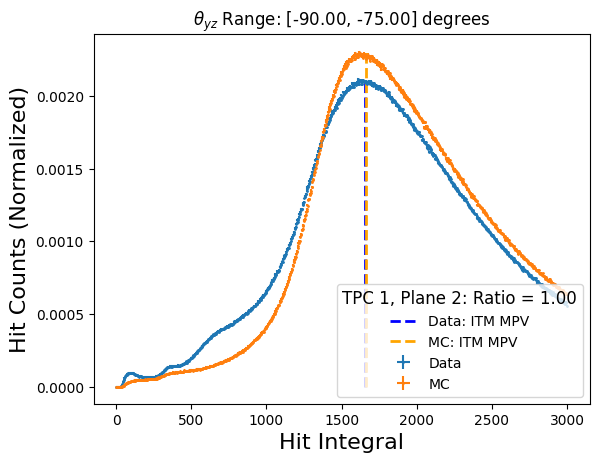

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [114]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(1).FindBin(-89)
        bin2 = hm.GetAxis(1).FindBin(-76)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        #plt.xlim(200, 1000)
        #if plane == 2:
        #    plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_neg_90_75.png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

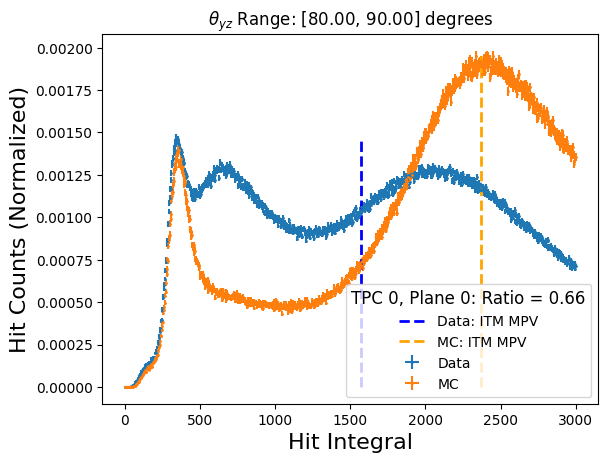

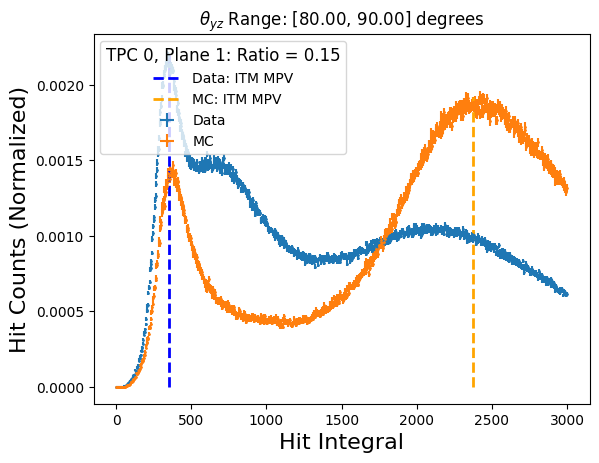

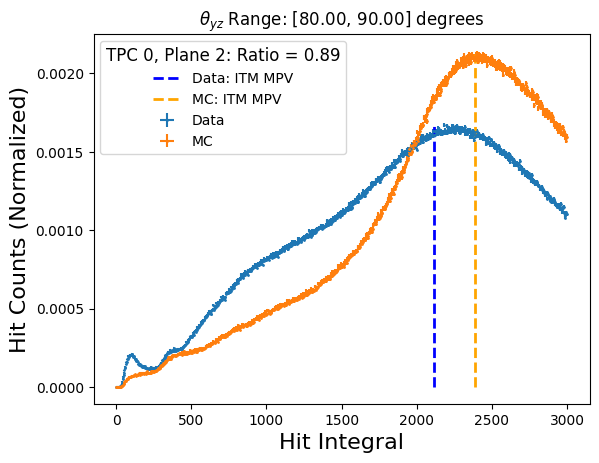

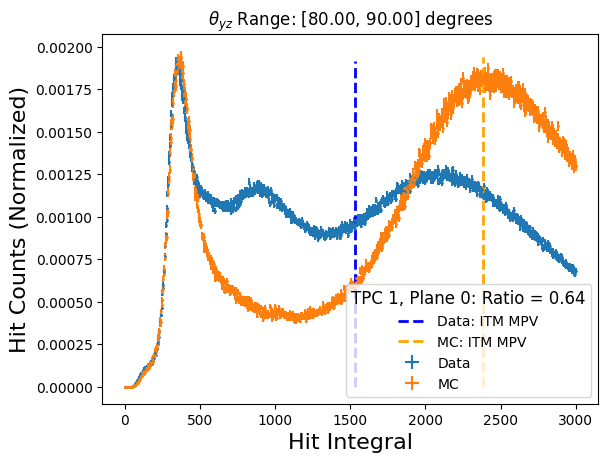

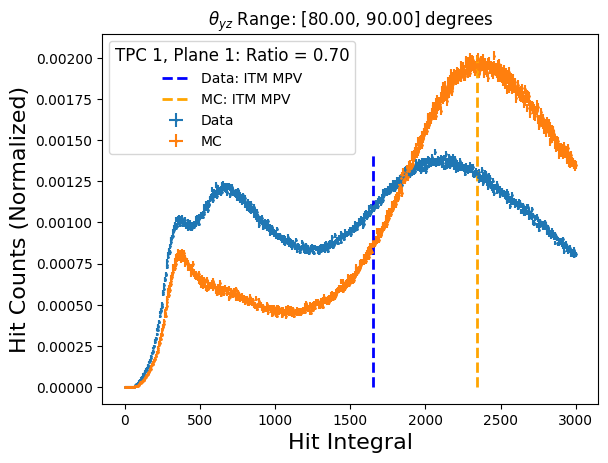

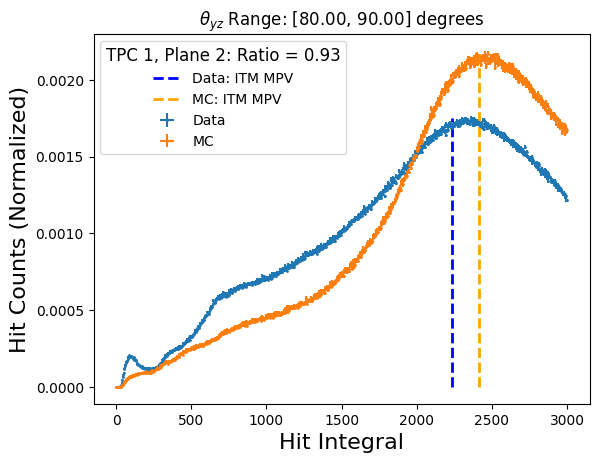

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [115]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(1).FindBin(81)
        bin2 = hm.GetAxis(1).FindBin(89)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        #plt.xlim(200, 1000)
        #if plane == 2:
        #    plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_pos_80_90.png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

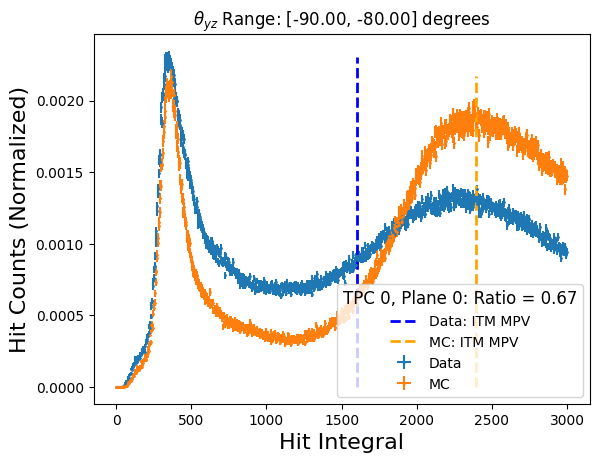

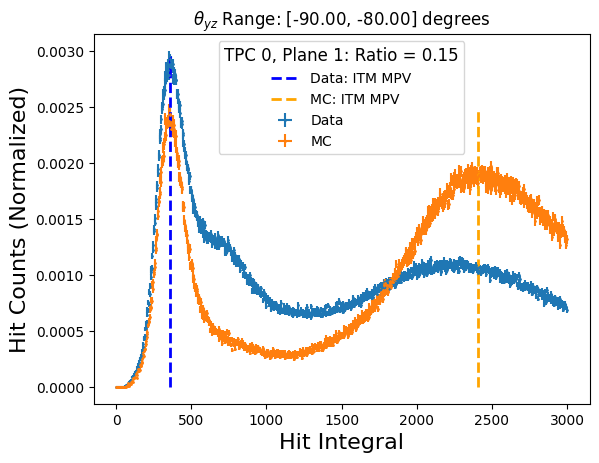

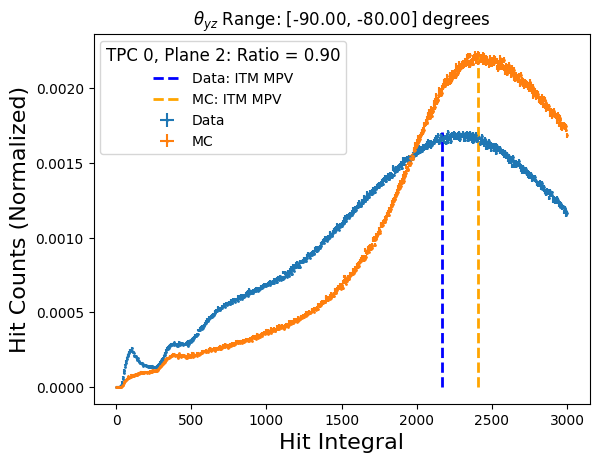

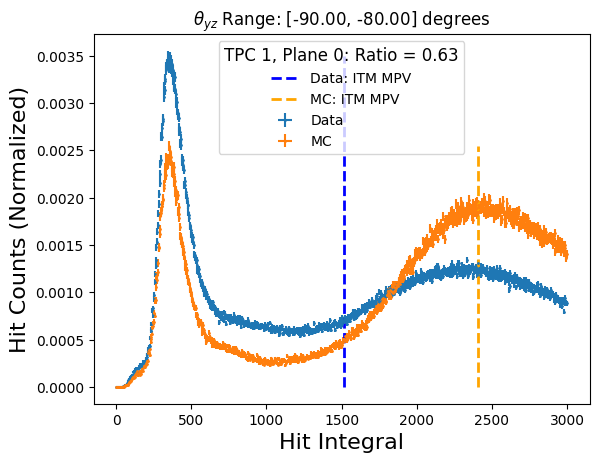

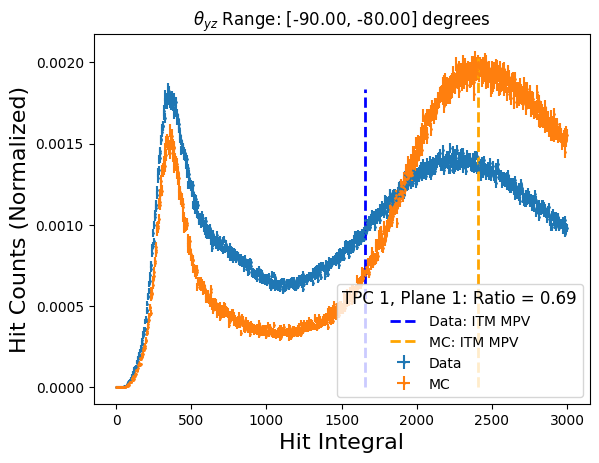

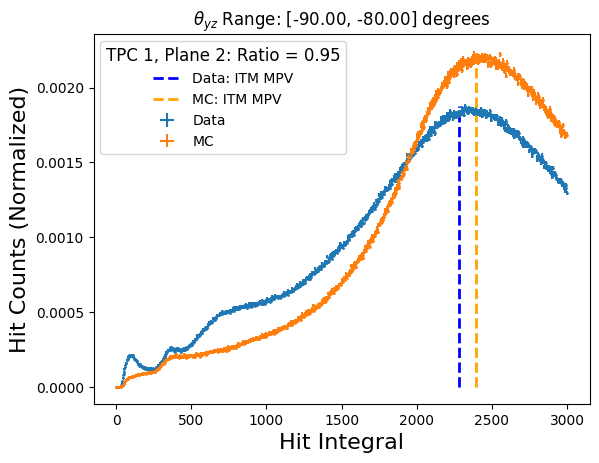

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [116]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(1).FindBin(-89)
        bin2 = hm.GetAxis(1).FindBin(-81)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        #plt.xlim(200, 1000)
        #if plane == 2:
        #    plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_neg_80_90.png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

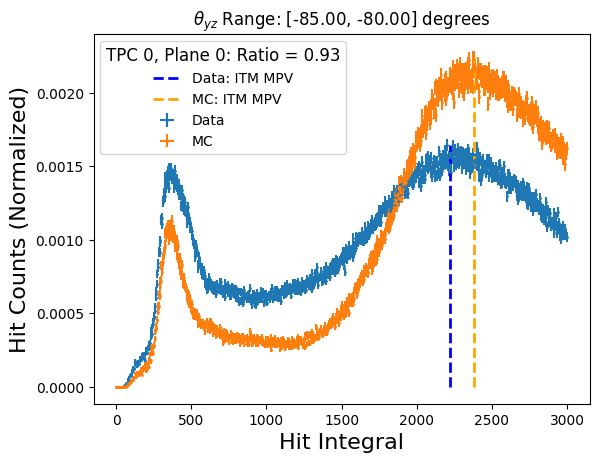

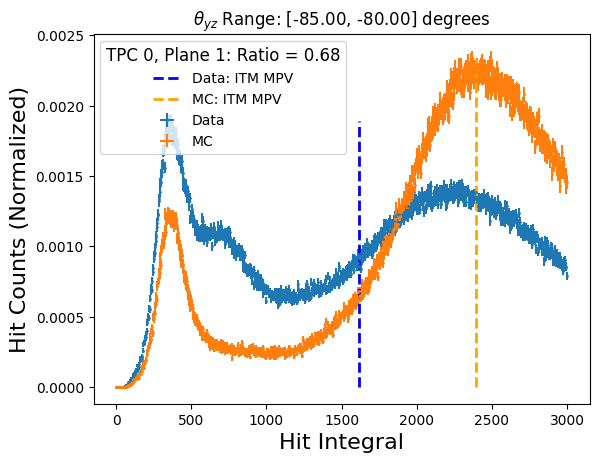

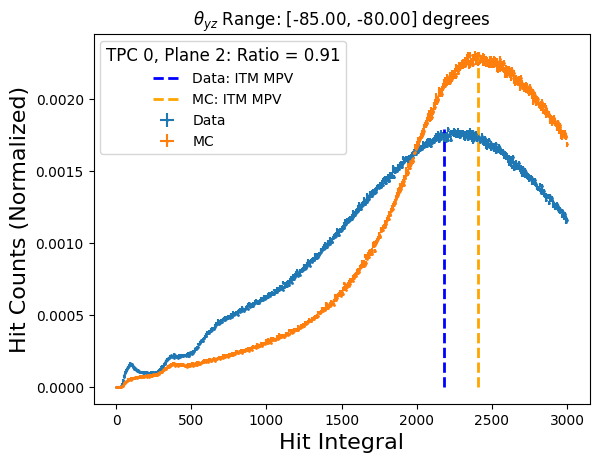

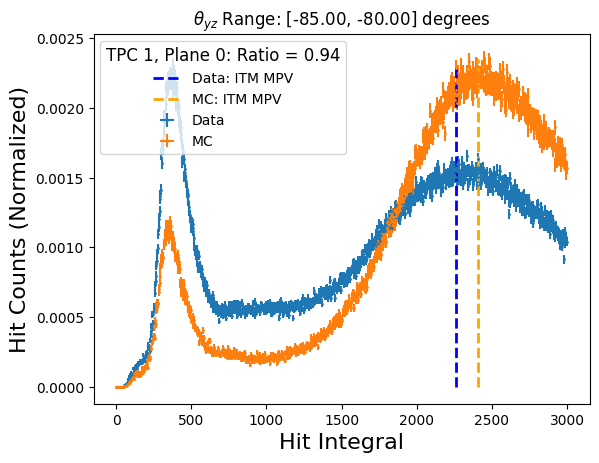

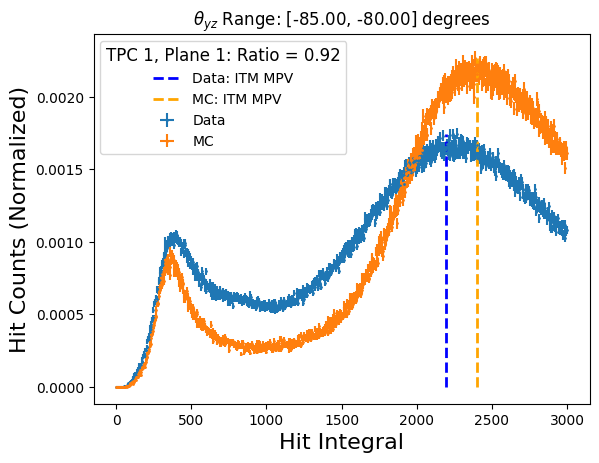

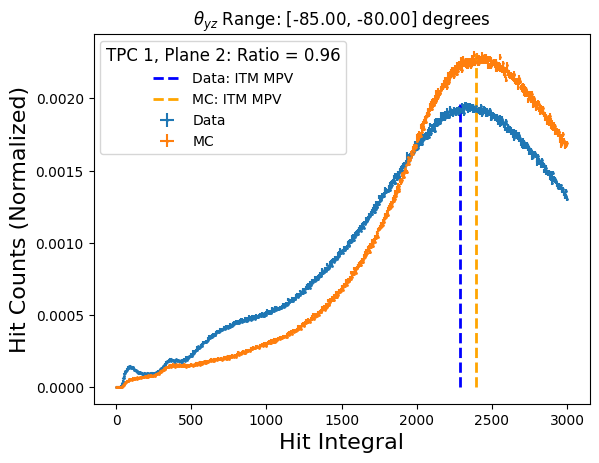

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [117]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(1).FindBin(-81)
        bin2 = hm.GetAxis(1).FindBin(-81)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        #plt.xlim(200, 1000)
        #if plane == 2:
        #    plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_neg_80_85.png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

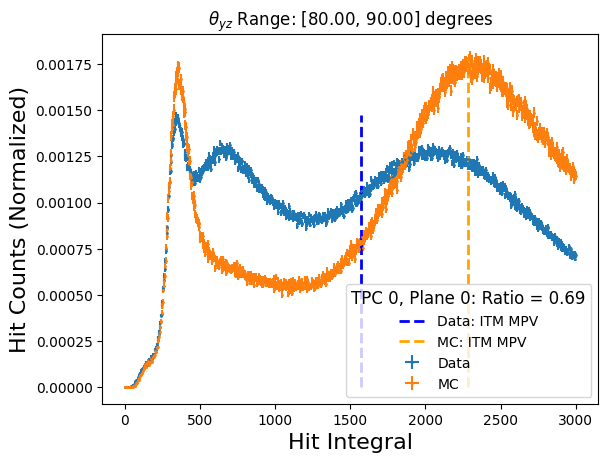

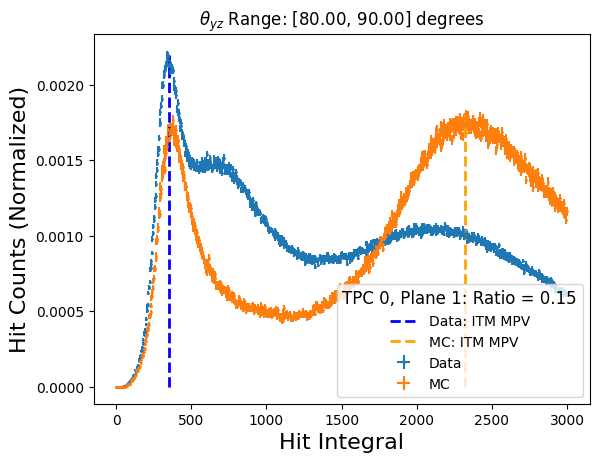

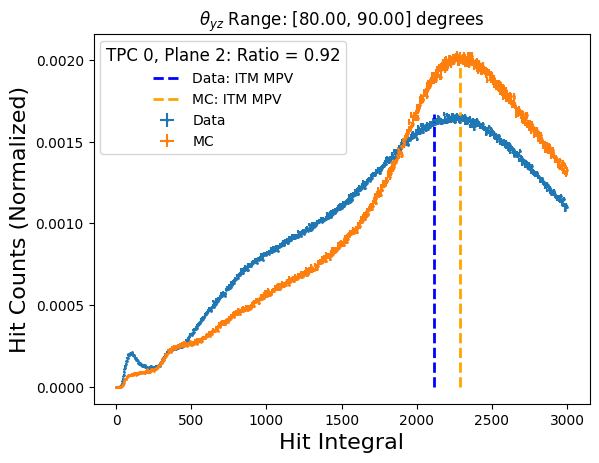

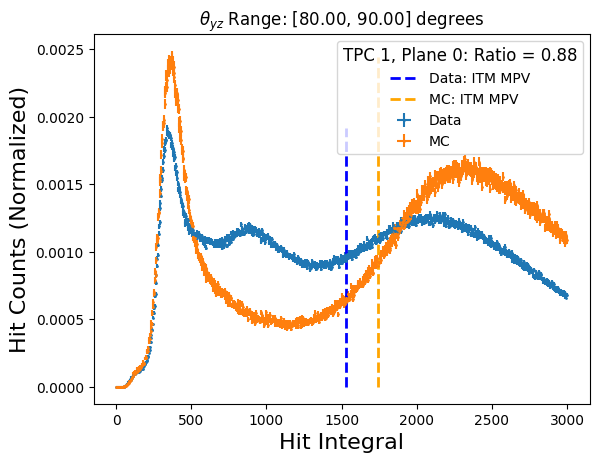

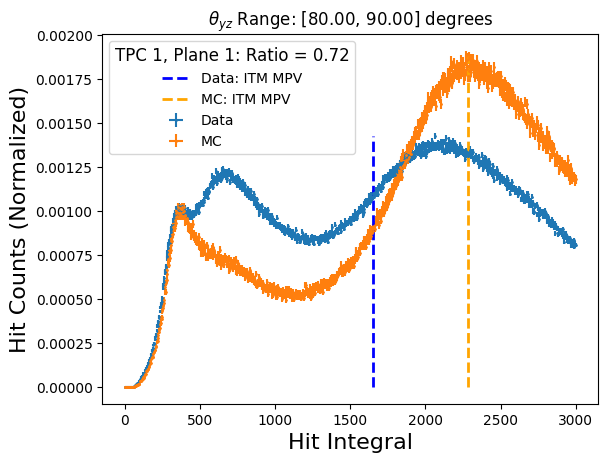

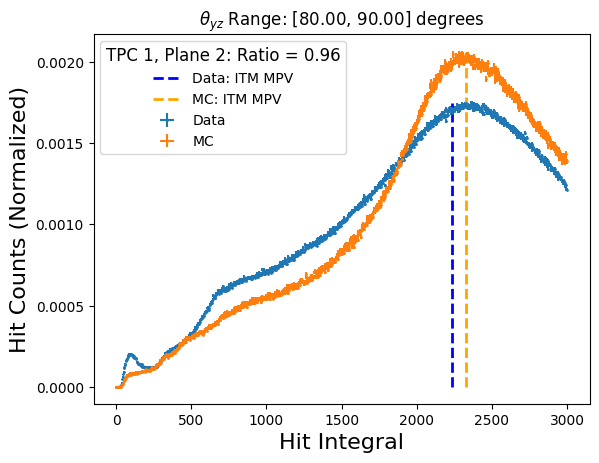

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [118]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(0).FindBin(-61)
        bin2 = hm.GetAxis(0).FindBin(61)

        hm.GetAxis(0).SetRange(bin1, bin2)

        bin1 = hm.GetAxis(1).FindBin(81)
        bin2 = hm.GetAxis(1).FindBin(89)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        #plt.xlim(200, 1000)
        #if plane == 2:
        #    plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_pos_80_90_cutxw_[-65,65].png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

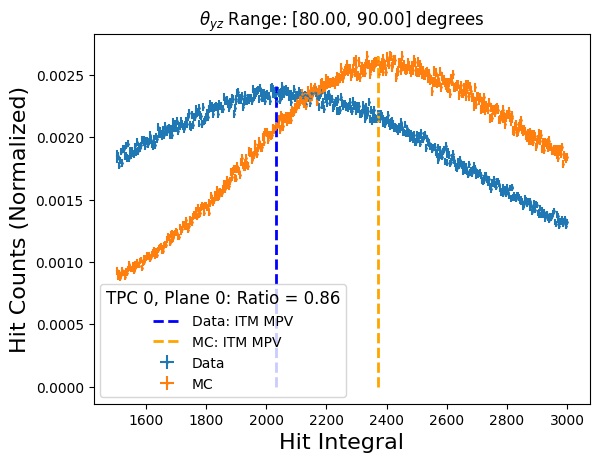

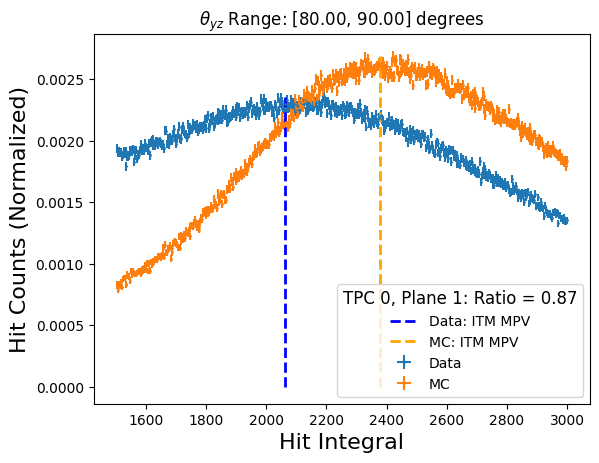

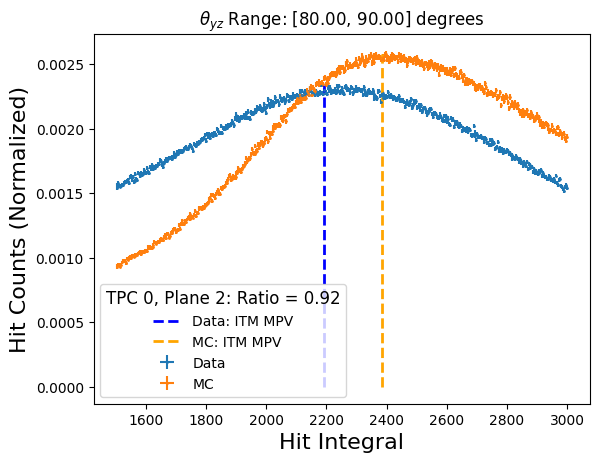

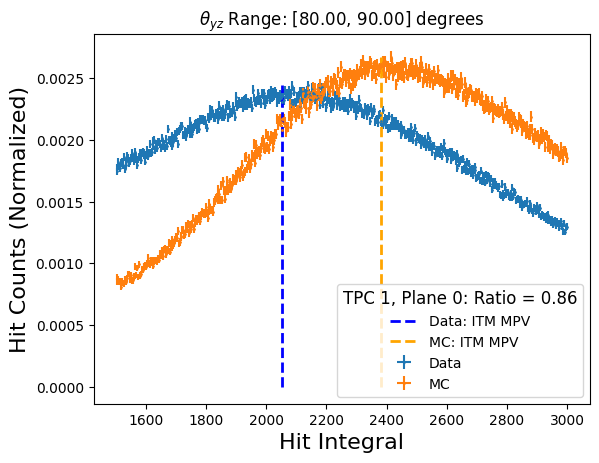

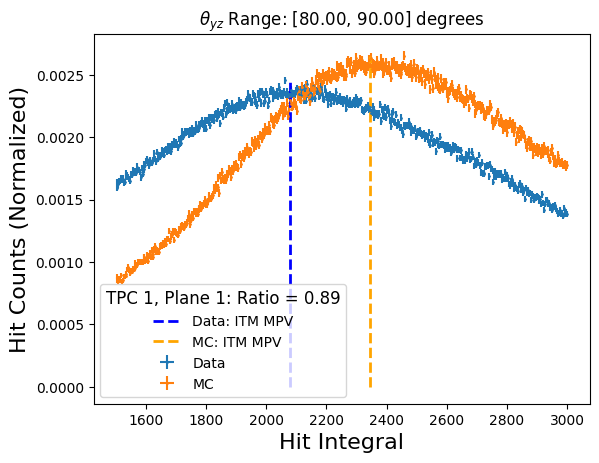

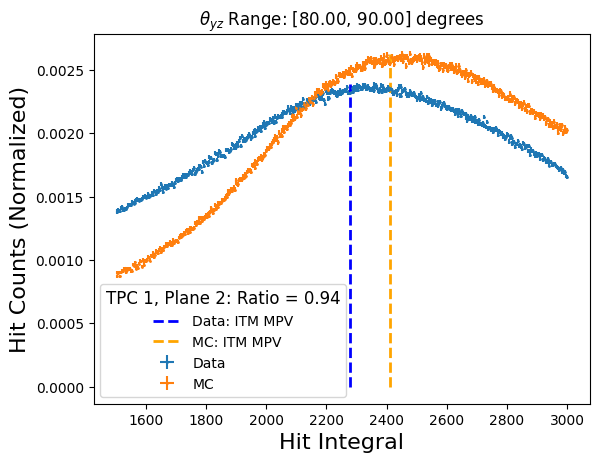

Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in

In [119]:
# investigate outliers
for tpc in range(2):    
    for plane in range(3):
        idx = tpc * 3 + plane


        hm = rmc_file.Get("hHit"+str(idx))
        hd = rdata_file.Get("hHit"+str(idx))

        bin1 = hm.GetAxis(2).FindBin(1500)
        hm.GetAxis(2).SetRange(bin1, hm.GetAxis(2).GetNbins()+1)
        hd.GetAxis(2).SetRange(bin1, hd.GetAxis(2).GetNbins()+1)

        bin1 = hm.GetAxis(1).FindBin(81)
        bin2 = hm.GetAxis(1).FindBin(89)

        xmin = hm.GetAxis(1).GetBinLowEdge(bin1)
        xmax = hm.GetAxis(1).GetBinLowEdge(bin2) + hm.GetAxis(1).GetBinWidth(bin2)

        hm.GetAxis(1).SetRange(bin1, bin2)
        hd.GetAxis(1).SetRange(bin1, bin2)

        hmq = hm.Projection(2)
        hdq = hd.Projection(2)

        result = array('d', [0.0, 0.0])
        ITM(hmq, -2.0, 1.75, 1e-4, result)

        mean_m = result[0]

        result = array('d', [0.0, 0.0])
        ITM(hdq, -2.0, 1.75, 1e-4, result)

        mean_d = result[0]

        r = mean_d / mean_m

        xd = get_bin_centers(hdq)
        yd = get_bin_content(hdq)
        wd = get_bin_width(hdq)

        xm = get_bin_centers(hmq)
        ym = get_bin_content(hmq)
        wm = get_bin_width(hmq)

        Nd= np.sum(yd)
        Nm= np.sum(ym)
        plt.errorbar(xd, yd/Nd, xerr=wd/2, yerr=np.sqrt(yd)/Nd, fmt='o', markersize=1, label='Data') 
        plt.errorbar(xm, ym/Nm, xerr=wm/2, yerr=np.sqrt(ym)/Nm, fmt='o', markersize=1, label='MC')
        plt.plot([mean_d, mean_d], [0, max(yd/Nd)], '--', linewidth=2, label='Data: ITM MPV', c='b')
        plt.plot([mean_m, mean_m], [0, max(ym/Nm)], '--', linewidth=2, label='MC: ITM MPV', c='orange')
        plt.xlabel('Hit Integral', fontsize=16) 
        plt.ylabel('Hit Counts (Normalized)', fontsize=16)
        plt.legend(title=f'TPC {tpc}, Plane {plane}: Ratio = {r:.2f}', fontsize=10, title_fontsize=12)
        plt.title(fr'$\theta_{{yz}}$ Range: [{xmin:.2f}, {xmax:.2f}] degrees', fontsize=12)
        #plt.xlim(200, 1000)
        #if plane == 2:
        #    plt.xlim(0, 1000)
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_HitIntegral_Comparison_pos_80_90_chargecut_[1500,3000].png", bbox_inches="tight")
        plt.show()

        hm.Delete()
        hd.Delete()

Plotting TPC 0, Plane 0, Index 0
Cutting charge for bin center: -87.5
Cutting charge for bin center: 82.5


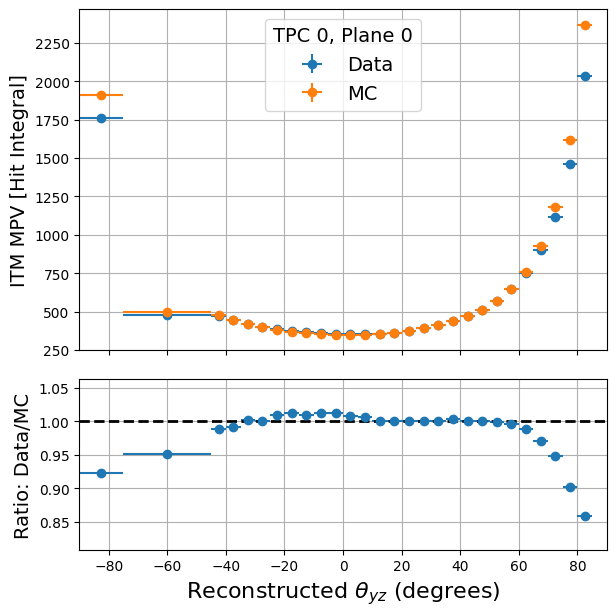

Plotting TPC 0, Plane 1, Index 1
Cutting charge for bin center: -87.5
Cutting charge for bin center: 82.5


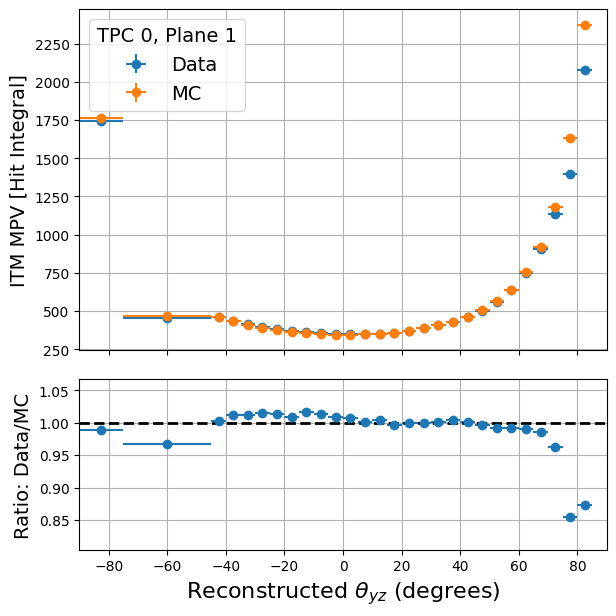

Plotting TPC 0, Plane 2, Index 2
Cutting charge for bin center: -87.5
Cutting charge for bin center: 82.5


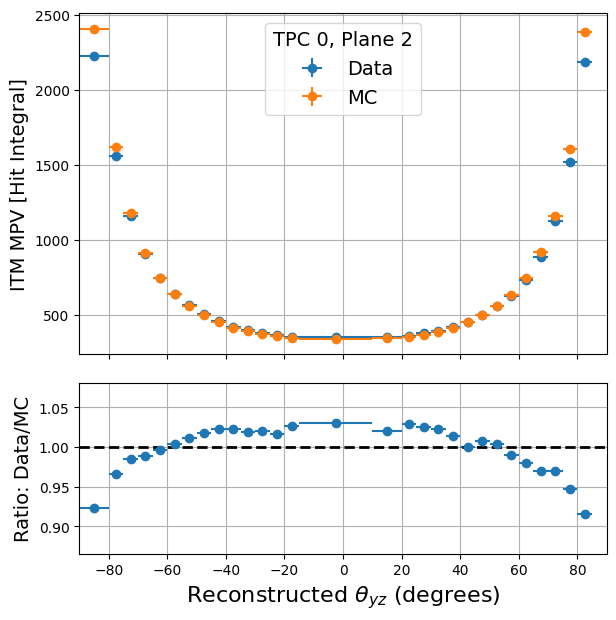

Plotting TPC 1, Plane 0, Index 3
Cutting charge for bin center: -87.5
Cutting charge for bin center: 82.5


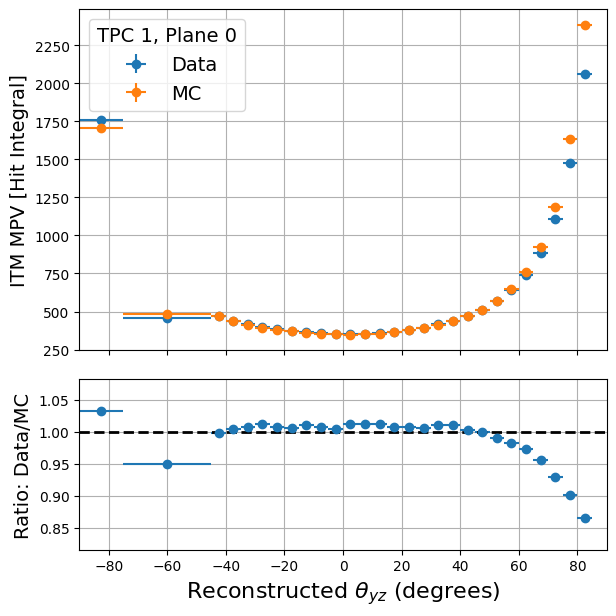

Plotting TPC 1, Plane 1, Index 4
Cutting charge for bin center: -87.5
Cutting charge for bin center: 82.5


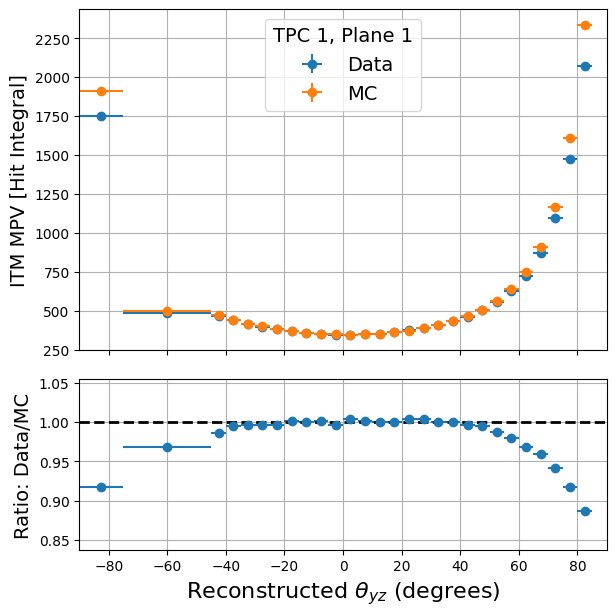

Plotting TPC 1, Plane 2, Index 5
Cutting charge for bin center: -87.5
Cutting charge for bin center: 82.5


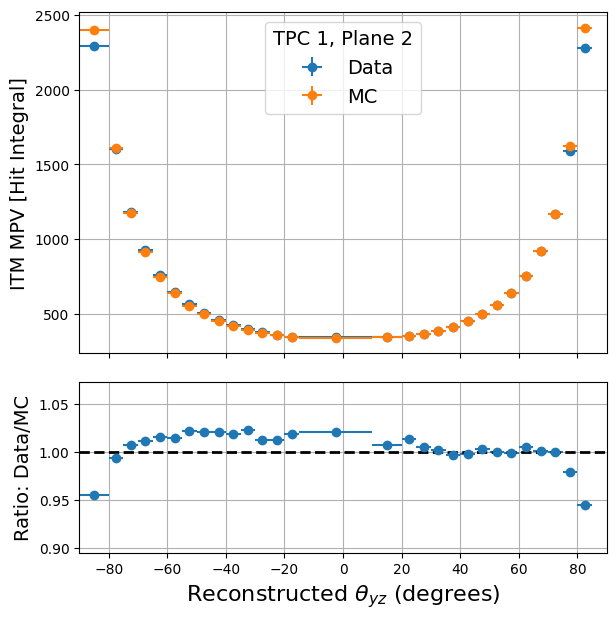

Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hTrack0_proj_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hHit0_proj_2 (Potential memory leak).


In [122]:
def get_mpv_variable_binning_chargecut(idx, dim, threshold=100000, cut_dim=None, cut=None):
    
    hd_trk = rdata_file.Get("hTrack"+str(idx))
    hm_trk = rmc_file.Get("hTrack"+str(idx))

    hd = rdata_file.Get("hHit"+str(idx))
    hm = rmc_file.Get("hHit"+str(idx))

    if cut_dim is not None and cut is not None:
        bin1 = hd_trk.GetAxis(cut_dim).FindBin(cut[0])
        bin2 = hd_trk.GetAxis(cut_dim).FindBin(cut[1])
        hd_trk.GetAxis(cut_dim).SetRange(bin1, bin2)
        hm_trk.GetAxis(cut_dim).SetRange(bin1, bin2)
        hd.GetAxis(cut_dim).SetRange(bin1, bin2)
        hm.GetAxis(cut_dim).SetRange(bin1, bin2)


    Ntrk_d = np.sum(get_bin_content(hd_trk.Projection(dim)))
    Ntrk_m = np.sum(get_bin_content(hm_trk.Projection(dim)))
  
    x = []
    w = []
    mpvs_m = []
    mpvs_d = []

    errors_d = []
    errors_m = []

    bins = []
    N = 0
    # Profile over the YZ bins
    for i in range(1, hd_trk.GetAxis(dim).GetNbins()+1):

        Ncurr = 0
        if Ntrk_d > Ntrk_m:
            hm_trk.GetAxis(dim).SetRange(i, i)
            Ncurr = hm_trk.Projection(dim).Integral()
        else:
            hd_trk.GetAxis(dim).SetRange(i, i)
            Ncurr = hd_trk.Projection(dim).Integral()

        if N + Ncurr > threshold:
            if len(bins) == 0:
                hd.GetAxis(dim).SetRange(i, i)
                hm.GetAxis(dim).SetRange(i, i)
                if hd.GetAxis(dim).GetBinCenter(i) < -81 or hd.GetAxis(dim).GetBinCenter(i) > 81:
                    print("Cutting charge for bin center:", hd.GetAxis(dim).GetBinCenter(i))
                    binc = hd.GetAxis(2).FindBin(1500)
                    hd.GetAxis(2).SetRange(binc, hd.GetAxis(2).GetNbins()+1)
                    hm.GetAxis(2).SetRange(binc, hm.GetAxis(2).GetNbins()+1)
                hq_d = hd.Projection(2)
                hq_m = hm.Projection(2)
                result = array('d', [0.0, 0.0])
                ITM(hq_d, -2.0, 1.75, 1e-4, result)
                mpvs_d.append(result[0])
                errors_d.append(result[1])
                result = array('d', [0.0, 0.0])
                ITM(hq_m, -2.0, 1.75, 1e-4, result)
                mpvs_m.append(result[0])
                errors_m.append(result[1])

                x.append(hm.GetAxis(dim).GetBinCenter(i))
                w.append(hm.GetAxis(dim).GetBinWidth(i))
                hd.GetAxis(2).SetRange(1, hd.GetAxis(2).GetNbins()+1)
                hm.GetAxis(2).SetRange(1, hm.GetAxis(2).GetNbins()+1)

            else:
                hd.GetAxis(dim).SetRange(bins[0], i)
                hm.GetAxis(dim).SetRange(bins[0], i)
                if hd.GetAxis(dim).GetBinCenter(bins[0]) < -81 or hd.GetAxis(dim).GetBinCenter(bins[0]) > 81:
                    print("Cutting charge for bin center:", hd.GetAxis(dim).GetBinCenter(bins[0]))
                    binc = hd.GetAxis(2).FindBin(1500)
                    hd.GetAxis(2).SetRange(binc, hd.GetAxis(2).GetNbins()+1)
                    hm.GetAxis(2).SetRange(binc, hm.GetAxis(2).GetNbins()+1)
                hq_d = hd.Projection(2)
                hq_m = hm.Projection(2)
                result = array('d', [0.0, 0.0])
                ITM(hq_d, -2.0, 1.75, 1e-4, result)
                mpvs_d.append(result[0])
                errors_d.append(result[1])
                result = array('d', [0.0, 0.0])
                ITM(hq_m, -2.0, 1.75, 1e-4, result)
                mpvs_m.append(result[0])
                errors_m.append(result[1])

                x.append((hm.GetAxis(dim).GetBinUpEdge(i) + hm.GetAxis(dim).GetBinLowEdge(bins[0]))/2)
                w.append((hm.GetAxis(dim).GetBinUpEdge(i) - hm.GetAxis(dim).GetBinLowEdge(bins[0])))
                hd.GetAxis(2).SetRange(1, hd.GetAxis(2).GetNbins()+1)
                hm.GetAxis(2).SetRange(1, hm.GetAxis(2).GetNbins()+1)
                
            N = 0
            bins = []

        else:
            bins.append(i)
            N += Ncurr

    return np.array(x), np.array(mpvs_d), np.array(mpvs_m), np.array(w), np.array(errors_d), np.array(errors_m)


for tpc in range(2):
    for plane in range(3):
        idx = tpc * 3 + plane
        print(f"Plotting TPC {tpc}, Plane {plane}, Index {idx}")

        fig, (ax1, ax2) = plt.subplots(
            2, 1,
            sharex=True,
            figsize=(6, 6),
            gridspec_kw={"height_ratios": [2, 1]}  
        )
        plt.tight_layout()

        x, yd, ym, w, err_d, err_m = get_mpv_variable_binning_chargecut(idx, 1, threshold=1000000)
        
        ax1.errorbar(x, yd, xerr=w/2, yerr=err_d, fmt='o', label='Data')
        ax1.errorbar(x, ym, xerr=w/2, yerr=err_m, fmt='o', label='MC')
        r = yd/ym
        r_err = r * np.sqrt( (err_d/yd)**2 + (err_m/ym)**2 )
        ax2.errorbar(x, yd/ym, xerr=w/2, yerr=r_err, fmt='o', label='Data/MC')

        ax2.set_xlabel(r'Reconstructed $\theta_{yz}$ (degrees)', fontsize=16)
        ax1.set_ylabel('ITM MPV [Hit Integral]', fontsize=14)
        ax1.grid()
        ax1.legend(title=f"TPC {tpc}, Plane {plane}", fontsize=14, title_fontsize=14)
        ax1.set_xlim(-90, 90)
        #ax1.set_ylim(0, 1800)
        ax2.set_ylim(np.min(r)-0.05, np.max(r)+0.05)
        ax2.plot([-90, 90], [1, 1], '--', linewidth=2, c="black")
        ax2.set_ylabel('Ratio: Data/MC', fontsize=14)
        ax2.grid()
        plt.savefig(Figure_Dir + f"AngleYZ_TPC{tpc}_Plane{plane}_Charge_Splines_1mil_chargecut.png", bbox_inches="tight")
        plt.show()
